In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4725, 15, 4)

In [9]:
v = X.reshape(X.shape[0],15, 4)
v[0]

array([[1.        , 1.        , 1.        , 1.        ],
       [0.75999985, 0.92783951, 0.78504654, 0.79689969],
       [0.64000015, 0.8402295 , 0.80601767, 0.70426669],
       [0.48000031, 0.73069638, 0.17089513, 0.49966137],
       [0.51999969, 0.64686477, 0.23230939, 0.62728573],
       [0.6       , 0.59363121, 0.35514026, 0.70140718],
       [0.71999969, 0.57513856, 0.56213184, 0.83332079],
       [0.51999969, 0.51523893, 0.24368262, 0.71510272],
       [0.48000031, 0.45570436, 0.20037465, 0.64782903],
       [0.55999985, 0.42302965, 0.33794397, 0.70140718],
       [0.35999985, 0.35112982, 0.06280271, 0.54255399],
       [0.4       , 0.29914193, 0.1967527 , 0.57822259],
       [0.15999985, 0.20204974, 0.        , 0.41944465],
       [0.08000031, 0.1021941 , 0.11630365, 0.18639476],
       [0.        , 0.        , 0.05751282, 0.        ]])

In [10]:
y = labels
y = np.array(y)
y.shape

(4725,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [127]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2983 - accuracy: 0.4971 - mse: 0.4618 - weighted_accuracy: 0.3179 - weighted_mse: 0.5294 - val_loss: 0.2995 - val_accuracy: 0.0444 - val_mse: 0.3543 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.3543
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2135 - accuracy: 0.3847 - mse: 0.7643 - weighted_accuracy: 0.4301 - weighted_mse: 0.7596 - val_loss: 0.2907 - val_accuracy: 0.0455 - val_mse: 0.3847 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3847
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1909 - accuracy: 0.3214 - mse: 1.0017 - weighted_accuracy: 0.4531 - weighted_mse: 0.9898 - val_loss: 0.2804 - val_accuracy: 0.0455 - val_mse: 0.4233 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.4233
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1829 - accuracy: 0.2937 - mse: 1.1482 - weighted_accuracy: 0.4874 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1383 - accuracy: 0.4333 - mse: 1.6018 - weighted_accuracy: 0.7016 - weighted_mse: 1.5375 - val_loss: 0.1804 - val_accuracy: 0.4381 - val_mse: 1.6404 - val_weighted_accuracy: 0.4381 - val_weighted_mse: 1.6404
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1381 - accuracy: 0.4646 - mse: 1.5954 - weighted_accuracy: 0.7038 - weighted_mse: 1.5436 - val_loss: 0.1856 - val_accuracy: 0.3979 - val_mse: 1.5944 - val_weighted_accuracy: 0.3979 - val_weighted_mse: 1.5944
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1359 - accuracy: 0.4360 - mse: 1.6228 - weighted_accuracy: 0.7174 - weighted_mse: 1.5549 - val_loss: 0.1829 - val_accuracy: 0.4466 - val_mse: 1.6237 - val_weighted_accuracy: 0.4466 - val_weighted_mse: 1.6237
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1360 - accuracy: 0.5016 - mse: 1.6341 - weighted_accuracy: 0.7340 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1128 - accuracy: 0.5749 - mse: 2.0762 - weighted_accuracy: 0.8034 - weighted_mse: 2.0762 - val_loss: 0.1556 - val_accuracy: 0.6032 - val_mse: 2.1236 - val_weighted_accuracy: 0.6032 - val_weighted_mse: 2.1236
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1119 - accuracy: 0.6212 - mse: 2.0448 - weighted_accuracy: 0.8150 - weighted_mse: 2.0471 - val_loss: 0.1777 - val_accuracy: 0.5111 - val_mse: 2.0837 - val_weighted_accuracy: 0.5111 - val_weighted_mse: 2.0837
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1114 - accuracy: 0.6040 - mse: 2.0887 - weighted_accuracy: 0.8049 - weighted_mse: 2.0859 - val_loss: 0.1872 - val_accuracy: 0.4899 - val_mse: 2.1337 - val_weighted_accuracy: 0.4899 - val_weighted_mse: 2.1337
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1108 - accuracy: 0.5820 - mse: 2.1241 - weighted_accuracy: 0.8116 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0886 - accuracy: 0.7122 - mse: 2.7640 - weighted_accuracy: 0.8741 - weighted_mse: 2.8230 - val_loss: 0.1877 - val_accuracy: 0.5481 - val_mse: 2.7337 - val_weighted_accuracy: 0.5481 - val_weighted_mse: 2.7337
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0852 - accuracy: 0.7177 - mse: 2.8043 - weighted_accuracy: 0.8836 - weighted_mse: 2.8943 - val_loss: 0.1518 - val_accuracy: 0.6434 - val_mse: 2.7619 - val_weighted_accuracy: 0.6434 - val_weighted_mse: 2.7619
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0862 - accuracy: 0.7106 - mse: 2.8423 - weighted_accuracy: 0.8773 - weighted_mse: 2.9442 - val_loss: 0.1947 - val_accuracy: 0.5280 - val_mse: 2.9457 - val_weighted_accuracy: 0.5280 - val_weighted_mse: 2.9457
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0873 - accuracy: 0.7288 - mse: 2.8305 - weighted_accuracy: 0.8729 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0685 - accuracy: 0.8140 - mse: 3.8008 - weighted_accuracy: 0.9245 - weighted_mse: 3.9604 - val_loss: 0.1858 - val_accuracy: 0.5905 - val_mse: 4.0242 - val_weighted_accuracy: 0.5905 - val_weighted_mse: 4.0242
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0649 - accuracy: 0.7905 - mse: 3.8170 - weighted_accuracy: 0.9176 - weighted_mse: 4.0026 - val_loss: 0.1490 - val_accuracy: 0.7175 - val_mse: 3.8718 - val_weighted_accuracy: 0.7175 - val_weighted_mse: 3.8718
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0646 - accuracy: 0.8127 - mse: 3.8512 - weighted_accuracy: 0.9240 - weighted_mse: 3.9941 - val_loss: 0.1708 - val_accuracy: 0.6455 - val_mse: 3.8315 - val_weighted_accuracy: 0.6455 - val_weighted_mse: 3.8315
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0643 - accuracy: 0.8061 - mse: 3.9459 - weighted_accuracy: 0.9271 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0528 - accuracy: 0.8563 - mse: 5.1955 - weighted_accuracy: 0.9400 - weighted_mse: 5.3467 - val_loss: 0.1650 - val_accuracy: 0.7291 - val_mse: 5.8006 - val_weighted_accuracy: 0.7291 - val_weighted_mse: 5.8006
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.8434 - mse: 5.2578 - weighted_accuracy: 0.9352 - weighted_mse: 5.3913 - val_loss: 0.1746 - val_accuracy: 0.6984 - val_mse: 5.2319 - val_weighted_accuracy: 0.6984 - val_weighted_mse: 5.2319
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0495 - accuracy: 0.8548 - mse: 5.2852 - weighted_accuracy: 0.9449 - weighted_mse: 5.4082 - val_loss: 0.1861 - val_accuracy: 0.7249 - val_mse: 5.4699 - val_weighted_accuracy: 0.7249 - val_weighted_mse: 5.4699
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0482 - accuracy: 0.8574 - mse: 5.3903 - weighted_accuracy: 0.9459 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.9021 - mse: 6.9771 - weighted_accuracy: 0.9623 - weighted_mse: 6.9934 - val_loss: 0.1878 - val_accuracy: 0.7376 - val_mse: 6.9462 - val_weighted_accuracy: 0.7376 - val_weighted_mse: 6.9462
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 0.8926 - mse: 6.9457 - weighted_accuracy: 0.9606 - weighted_mse: 6.9537 - val_loss: 0.2009 - val_accuracy: 0.7323 - val_mse: 7.3826 - val_weighted_accuracy: 0.7323 - val_weighted_mse: 7.3826
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0371 - accuracy: 0.9024 - mse: 7.1146 - weighted_accuracy: 0.9605 - weighted_mse: 7.1090 - val_loss: 0.1914 - val_accuracy: 0.7333 - val_mse: 7.1280 - val_weighted_accuracy: 0.7333 - val_weighted_mse: 7.1280
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0392 - accuracy: 0.8979 - mse: 7.1211 - weighted_accuracy: 0.9533 - 

In [128]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21242688596248627
Test accuracy: 0.7830687761306763


In [129]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5940857  -4.7985425   1.2671664 ]
 [-1.9623553  -3.4673057   1.1055369 ]
 [-4.114557   -4.7069993   3.1214373 ]
 ...
 [-4.281307   -3.5735772   2.1278396 ]
 [-2.577865   -4.5735126   1.7658176 ]
 [-4.5707593  -0.47593436 -0.11394811]]


Counter({2: 809, 0: 59, 1: 77})

In [130]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [131]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 945
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 38
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 39
actual holds but predicted buy: 71
actual holds but predicted sell: 56
actual predicted holds: 732
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 85.21536670547148%
actual buys: 43
actual sells: 43
actual holds: 859


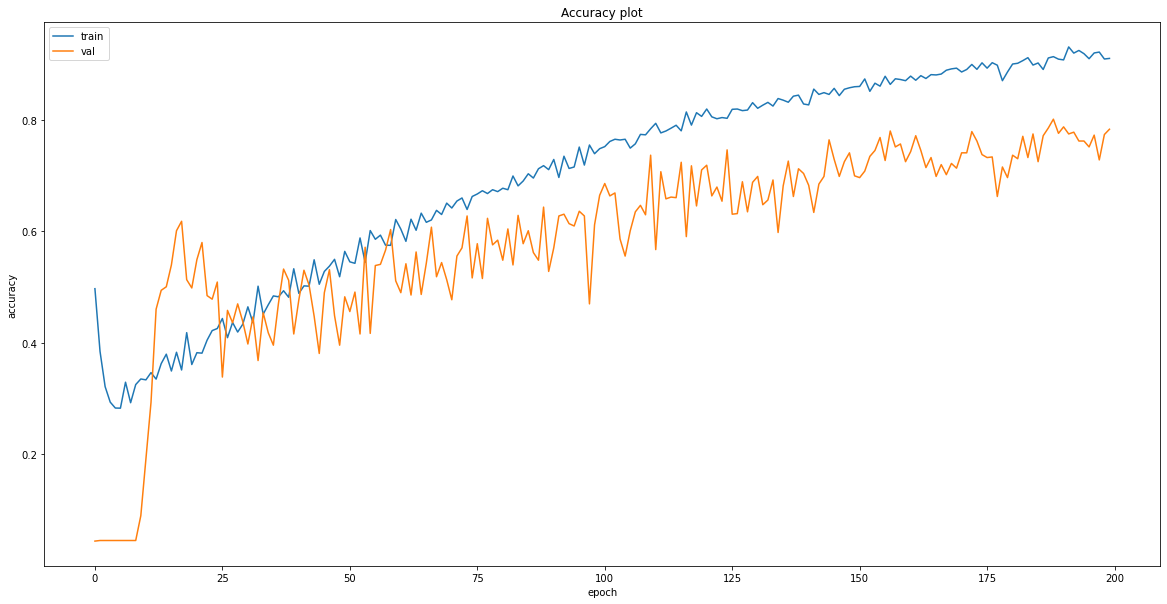

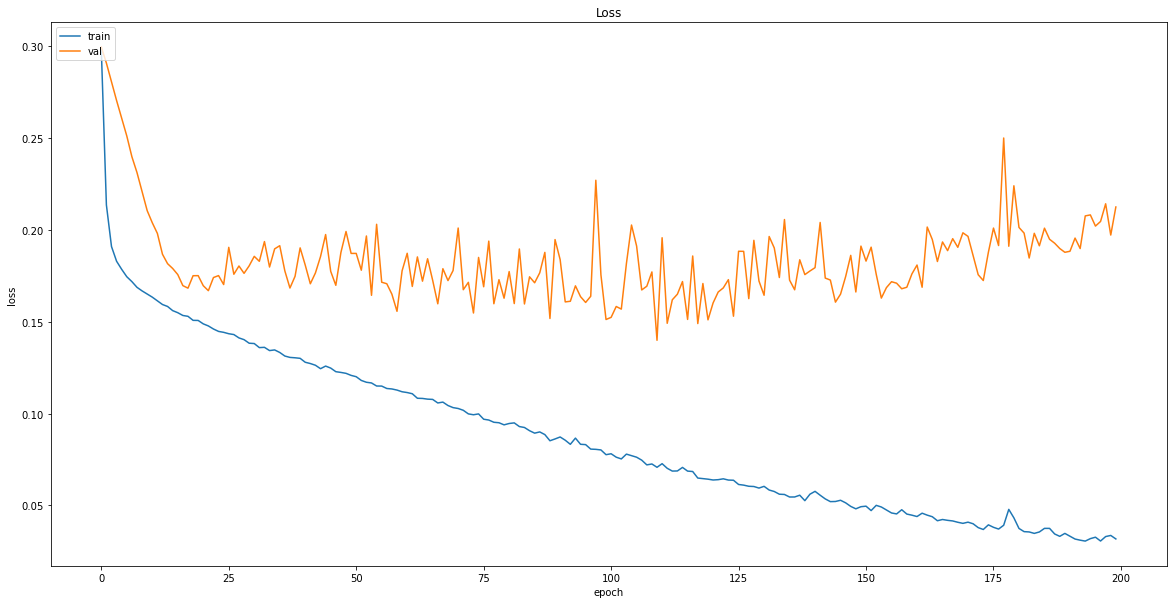

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [133]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [134]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [135]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [136]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [137]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [138]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1920 - accuracy: 0.7615 - mean_squared_error: 8.7056 - weighted_accuracy: 0.7615 - weighted_mean_squared_error: 8.7056
Test loss: 0.19198393821716309
Test accuracy: 0.7614678740501404


In [139]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 176, 0: 18, 1: 24})

In [140]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [141]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [142]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,9.76,9.644474,-45.454598,5084100.0,2.0,2,2
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2


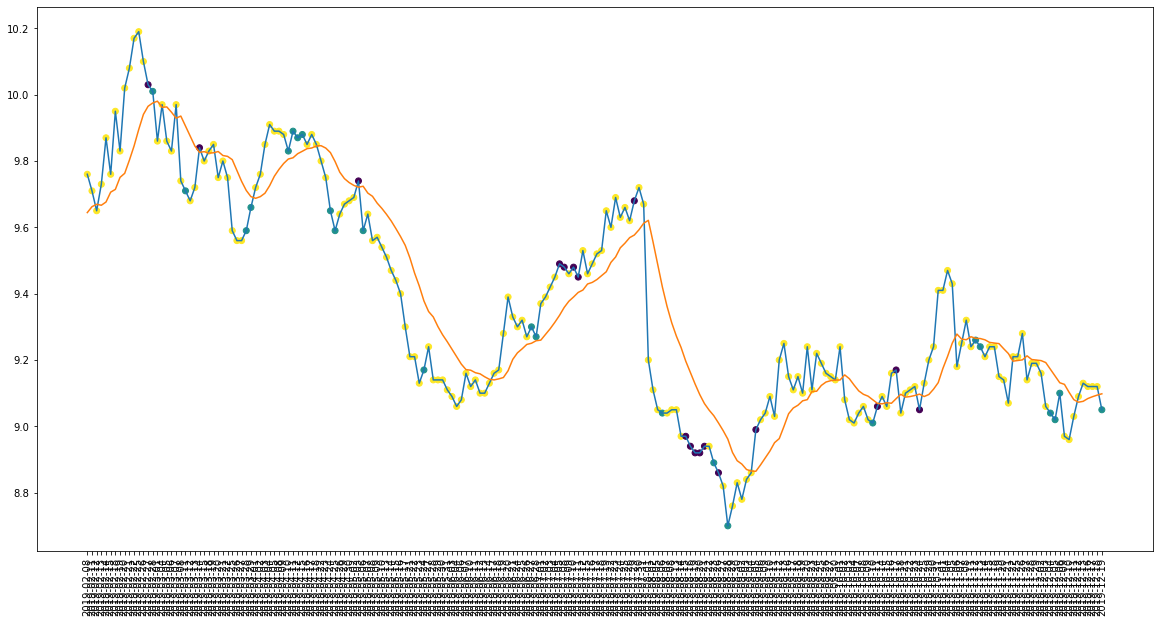

In [143]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [144]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 17
actual predicted holds: 162
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 81.0%
actual buys: 9
actual sells: 9
actual holds: 200


In [145]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672]
[9.829999923706056, 9.949999809265137, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 81.25%


In [146]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672]
[9.829999923706056, 9.949999809265137, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 81.25%


In [147]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.010000228881836
Shares owned at the moment: 996
Cash capital at the moment: $2.622381406783461


Stop Loss Activated!

Share price: $9.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9647.186729296684


Share price: $9.710000038146973
Shares owned at the moment: 990
Cash capital at the moment: $7.851216427325198


Stop Loss Activated!

Share price: $9.4399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9327.750402149199


Share price: $9.170000076293944
Shares owned at the moment: 1014
Cash capital at the moment: $3.7997795743940515


Price increase from previously bought: 5.272118083543531%
Share price: $9.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9792.327408171652


Share price: $9.039999961853027
Shares owned at the moment: 1080
Cash capital at the moment: $2.2786494836782367


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment:

In [148]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9222.27618237376
profit gained: -7.777238176262399%


### Recession

In [149]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


In [150]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [151]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(215, 15, 4)

In [152]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [153]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2054 - accuracy: 0.7674 - mean_squared_error: 8.1591 - weighted_accuracy: 0.7674 - weighted_mean_squared_error: 8.1591
Test loss: 0.2054370641708374
Test accuracy: 0.7674418687820435


In [154]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 0: 6, 1: 29})

In [155]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [156]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [157]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,8.53,8.641035,-89.830440,-3476200.0,2.0,2,2
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,2,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,2,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,0,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,2,2


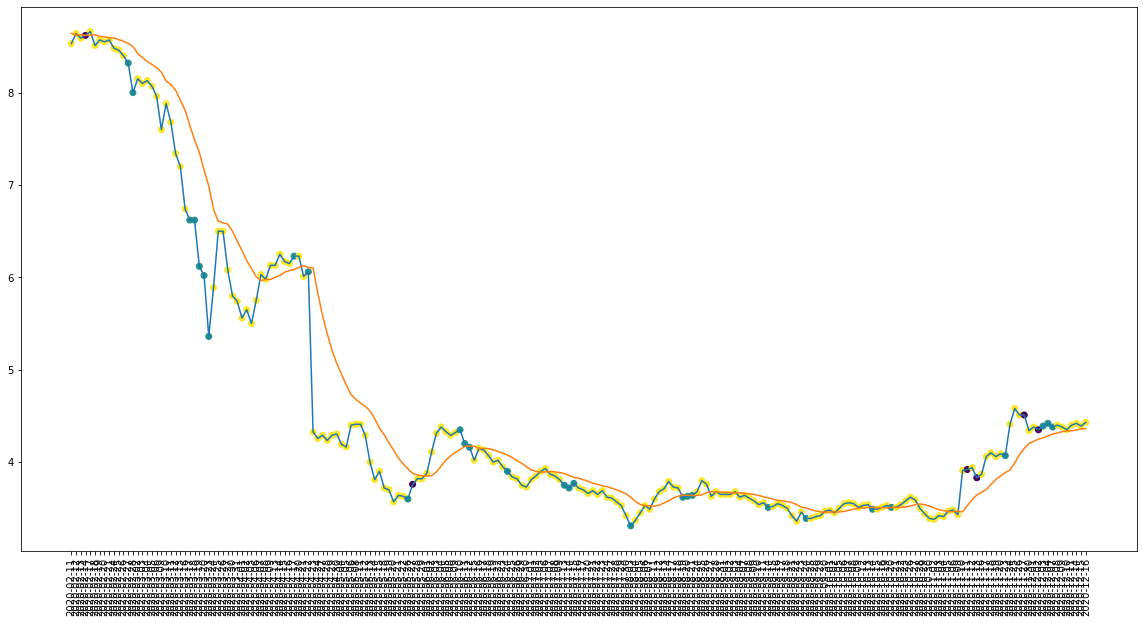

In [158]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [159]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 28
actual holds but predicted sell: 6
actual predicted holds: 164
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 82.82828282828282%
actual buys: 8
actual sells: 9
actual holds: 198


In [160]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.510000228881836, 8.529999732971191, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219, 8.569999694824219]
Percentage buys correct: 62.06896551724138%
Percentage sells correct: 50.0%
Percentage holds correct: 86.11111111111111%


In [161]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.319999694824219
Shares owned at the moment: 1198
Cash capital at the moment: $5.230126605987607


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9562.874126605988


Share price: $8.0
Shares owned at the moment: 1192
Cash capital at the moment: $0.6501266059876798


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $9034.93721324062


Share price: $6.619999885559082
Shares owned at the moment: 1361
Cash capital at the moment: $0.3403644230329519


Stop Loss Activated!

Share price: $6.119999885559082
Shares owned at the moment: 0
Cash capital at the moment: $8306.754579097267


Share price: $6.119999885559082
Shares owned at the moment: 1353
Cash capital at the moment: $3.623744361635545


Stop Loss Activated!

Share price: $5.360000133514403
Shares owned at the moment: 0
Cash capital at the moment: $7235.760704509849


Share price: $5.360000133514403
Shares 

In [162]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5165.4369528948055
profit gained: -48.34563047105195%


### OCBC Bank

In [163]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [164]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [165]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [166]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4789, 15, 4)

In [167]:
y = labels
y = np.array(y)

In [168]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [170]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [171]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [172]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [173]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2919 - accuracy: 0.4952 - mse: 0.4530 - weighted_accuracy: 0.2891 - weighted_mse: 0.5245 - val_loss: 0.2997 - val_accuracy: 0.0407 - val_mse: 0.3554 - val_weighted_accuracy: 0.0407 - val_weighted_mse: 0.3554
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2077 - accuracy: 0.3430 - mse: 0.7849 - weighted_accuracy: 0.4637 - weighted_mse: 0.7616 - val_loss: 0.2908 - val_accuracy: 0.0418 - val_mse: 0.3854 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3854
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1864 - accuracy: 0.2999 - mse: 1.0359 - weighted_accuracy: 0.5058 - weighted_mse: 0.9983 - val_loss: 0.2794 - val_accuracy: 0.0418 - val_mse: 0.4223 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4223
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1779 - accuracy: 0.2746 - mse: 1.2004 - weighted_accuracy: 0.5207 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1279 - accuracy: 0.4195 - mse: 1.8705 - weighted_accuracy: 0.7413 - weighted_mse: 1.7796 - val_loss: 0.1790 - val_accuracy: 0.4541 - val_mse: 1.8893 - val_weighted_accuracy: 0.4541 - val_weighted_mse: 1.8893
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1272 - accuracy: 0.4534 - mse: 1.8799 - weighted_accuracy: 0.7348 - weighted_mse: 1.8022 - val_loss: 0.1826 - val_accuracy: 0.4332 - val_mse: 1.8896 - val_weighted_accuracy: 0.4332 - val_weighted_mse: 1.8896
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1262 - accuracy: 0.4704 - mse: 1.8832 - weighted_accuracy: 0.7543 - weighted_mse: 1.8001 - val_loss: 0.2048 - val_accuracy: 0.3466 - val_mse: 1.9099 - val_weighted_accuracy: 0.3466 - val_weighted_mse: 1.9099
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1255 - accuracy: 0.4636 - mse: 1.9034 - weighted_accuracy: 0.7495 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1011 - accuracy: 0.5975 - mse: 2.5711 - weighted_accuracy: 0.8227 - weighted_mse: 2.5464 - val_loss: 0.1796 - val_accuracy: 0.5063 - val_mse: 2.7400 - val_weighted_accuracy: 0.5063 - val_weighted_mse: 2.7400
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1018 - accuracy: 0.6163 - mse: 2.5922 - weighted_accuracy: 0.8206 - weighted_mse: 2.6002 - val_loss: 0.1628 - val_accuracy: 0.6044 - val_mse: 2.5747 - val_weighted_accuracy: 0.6044 - val_weighted_mse: 2.5747
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0999 - accuracy: 0.6197 - mse: 2.6183 - weighted_accuracy: 0.8367 - weighted_mse: 2.5842 - val_loss: 0.1720 - val_accuracy: 0.5605 - val_mse: 2.7779 - val_weighted_accuracy: 0.5605 - val_weighted_mse: 2.7779
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0978 - accuracy: 0.6236 - mse: 2.6358 - weighted_accuracy: 0.8439 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0771 - accuracy: 0.7288 - mse: 3.5344 - weighted_accuracy: 0.8933 - weighted_mse: 3.5322 - val_loss: 0.1666 - val_accuracy: 0.6086 - val_mse: 3.5046 - val_weighted_accuracy: 0.6086 - val_weighted_mse: 3.5046
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0778 - accuracy: 0.7314 - mse: 3.6416 - weighted_accuracy: 0.8925 - weighted_mse: 3.5944 - val_loss: 0.1538 - val_accuracy: 0.6775 - val_mse: 4.1152 - val_weighted_accuracy: 0.6775 - val_weighted_mse: 4.1152
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0749 - accuracy: 0.7617 - mse: 3.6521 - weighted_accuracy: 0.9019 - weighted_mse: 3.6171 - val_loss: 0.1728 - val_accuracy: 0.6127 - val_mse: 3.8624 - val_weighted_accuracy: 0.6127 - val_weighted_mse: 3.8624
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0747 - accuracy: 0.7377 - mse: 3.7360 - weighted_accuracy: 0.8932 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0607 - accuracy: 0.8199 - mse: 4.9781 - weighted_accuracy: 0.9212 - weighted_mse: 4.7737 - val_loss: 0.1830 - val_accuracy: 0.6482 - val_mse: 5.2459 - val_weighted_accuracy: 0.6482 - val_weighted_mse: 5.2459
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0596 - accuracy: 0.8202 - mse: 4.9854 - weighted_accuracy: 0.9343 - weighted_mse: 4.8518 - val_loss: 0.1672 - val_accuracy: 0.7098 - val_mse: 5.2336 - val_weighted_accuracy: 0.7098 - val_weighted_mse: 5.2336
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0549 - accuracy: 0.8196 - mse: 4.9363 - weighted_accuracy: 0.9305 - weighted_mse: 4.7782 - val_loss: 0.1509 - val_accuracy: 0.7443 - val_mse: 5.6131 - val_weighted_accuracy: 0.7443 - val_weighted_mse: 5.6131
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0584 - accuracy: 0.8256 - mse: 5.1523 - weighted_accuracy: 0.9251 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0432 - accuracy: 0.8818 - mse: 6.8044 - weighted_accuracy: 0.9530 - weighted_mse: 6.3059 - val_loss: 0.1880 - val_accuracy: 0.7370 - val_mse: 6.9447 - val_weighted_accuracy: 0.7370 - val_weighted_mse: 6.9447
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0409 - accuracy: 0.8851 - mse: 6.8810 - weighted_accuracy: 0.9544 - weighted_mse: 6.4205 - val_loss: 0.1959 - val_accuracy: 0.7140 - val_mse: 7.0671 - val_weighted_accuracy: 0.7140 - val_weighted_mse: 7.0671
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 0.8752 - mse: 6.9252 - weighted_accuracy: 0.9526 - weighted_mse: 6.4495 - val_loss: 0.1864 - val_accuracy: 0.7328 - val_mse: 7.4009 - val_weighted_accuracy: 0.7328 - val_weighted_mse: 7.4009
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0384 - accuracy: 0.8930 - mse: 7.1048 - weighted_accuracy: 0.9591 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0319 - accuracy: 0.9159 - mse: 9.0158 - weighted_accuracy: 0.9675 - weighted_mse: 8.1300 - val_loss: 0.2046 - val_accuracy: 0.7797 - val_mse: 9.6377 - val_weighted_accuracy: 0.7797 - val_weighted_mse: 9.6377
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0355 - accuracy: 0.9068 - mse: 9.1194 - weighted_accuracy: 0.9602 - weighted_mse: 8.1803 - val_loss: 0.1795 - val_accuracy: 0.8403 - val_mse: 10.7373 - val_weighted_accuracy: 0.8403 - val_weighted_mse: 10.7373
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0339 - accuracy: 0.9136 - mse: 9.3042 - weighted_accuracy: 0.9646 - weighted_mse: 8.3340 - val_loss: 0.1985 - val_accuracy: 0.7891 - val_mse: 10.0528 - val_weighted_accuracy: 0.7891 - val_weighted_mse: 10.0528
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0317 - accuracy: 0.9214 - mse: 9.3021 - weighted_accuracy: 0.969

In [174]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22504040598869324
Test accuracy: 0.7797494530677795


In [175]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-5.488013   -6.219019    4.603238  ]
 [-3.7562766  -1.4120723   0.7969743 ]
 [-4.9695234  -4.675083    3.6991622 ]
 ...
 [-2.2186491  -3.5804982   1.5276724 ]
 [-0.73981124 -4.4948797   0.48103186]
 [-1.3864869  -4.8873234   1.6112221 ]]


Counter({2: 807, 0: 73, 1: 78})

In [176]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [177]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 958
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 40
actual holds but predicted buy: 69
actual holds but predicted sell: 69
actual predicted holds: 736
Percentage buys correct: 20.0%
Percentage sells correct: 6.818181818181818%
Percentage holds correct: 84.21052631578948%
actual buys: 40
actual sells: 44
actual holds: 874


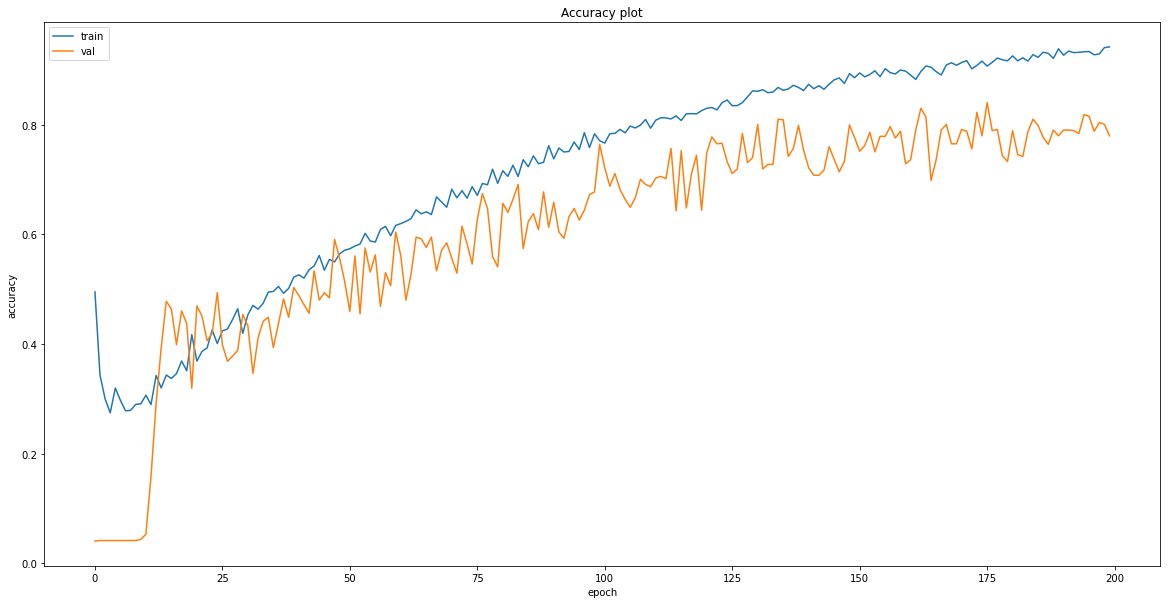

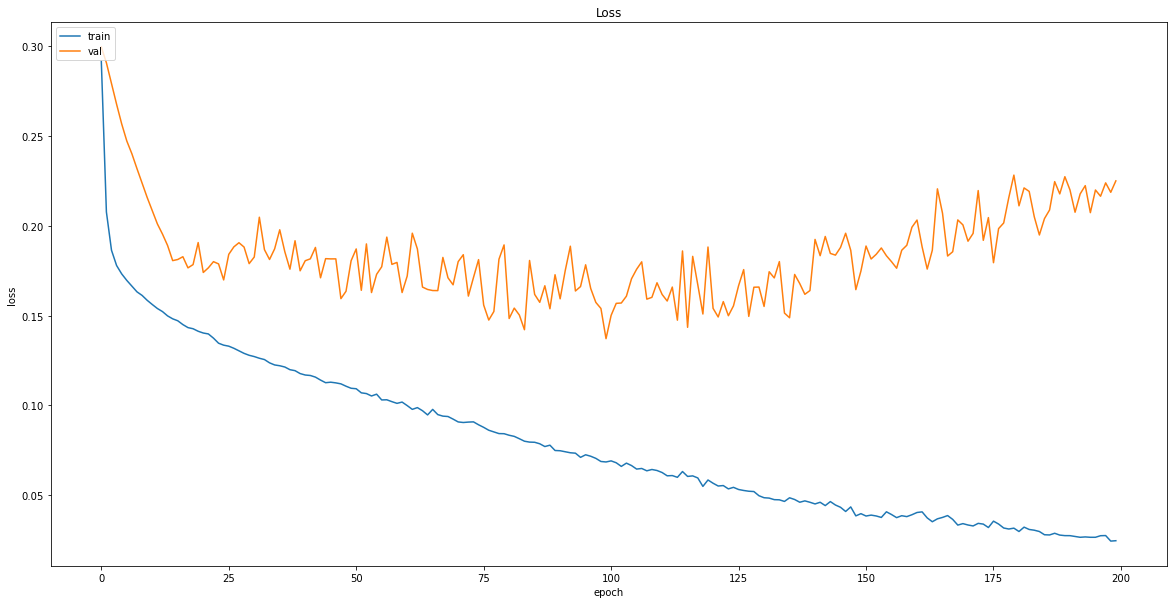

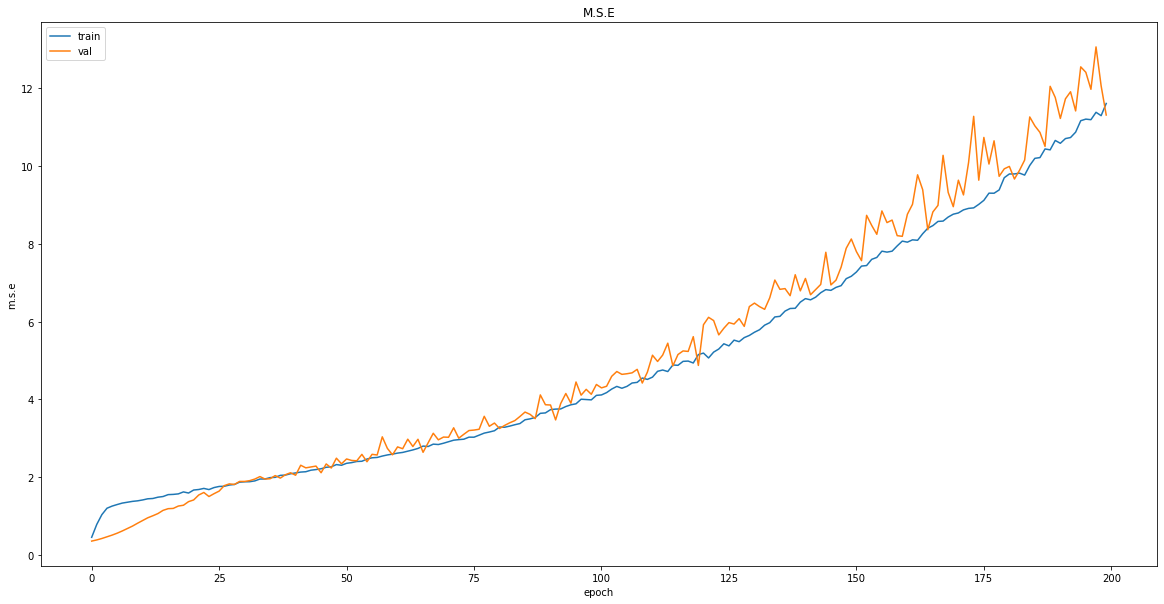

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [179]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [180]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [181]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [182]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [183]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [184]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2587 - accuracy: 0.7523 - mean_squared_error: 12.3278 - weighted_accuracy: 0.7523 - weighted_mean_squared_error: 12.3278
Test loss: 0.2587158977985382
Test accuracy: 0.752293586730957


In [185]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 173, 0: 20, 1: 25})

In [186]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [187]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [188]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,2,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,0,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,0,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,2,2


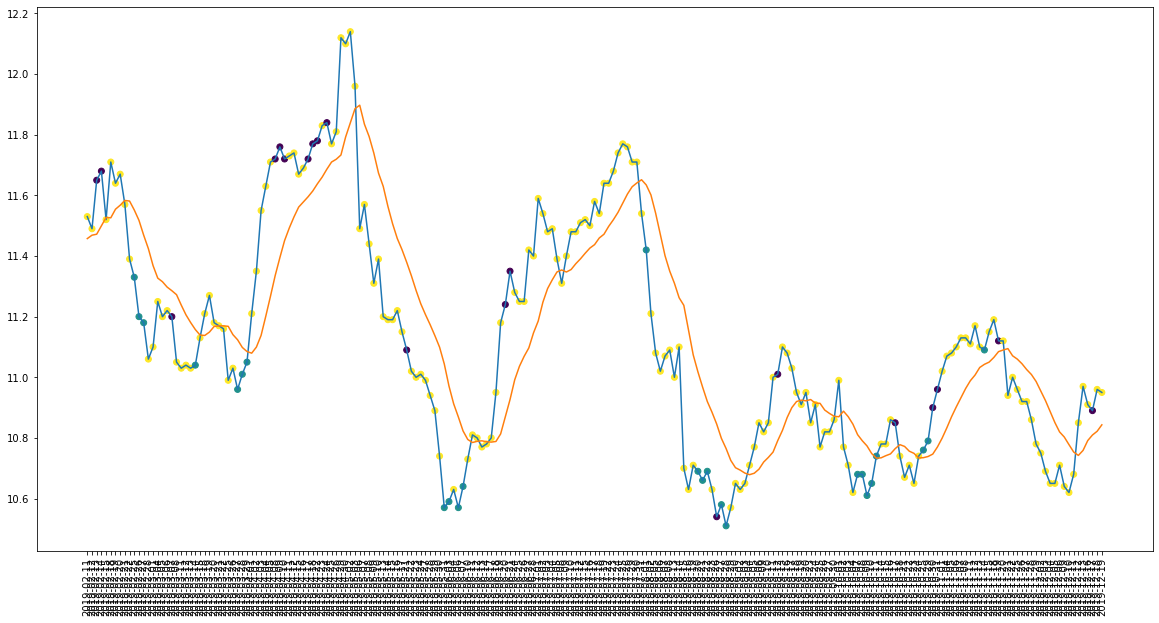

In [189]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

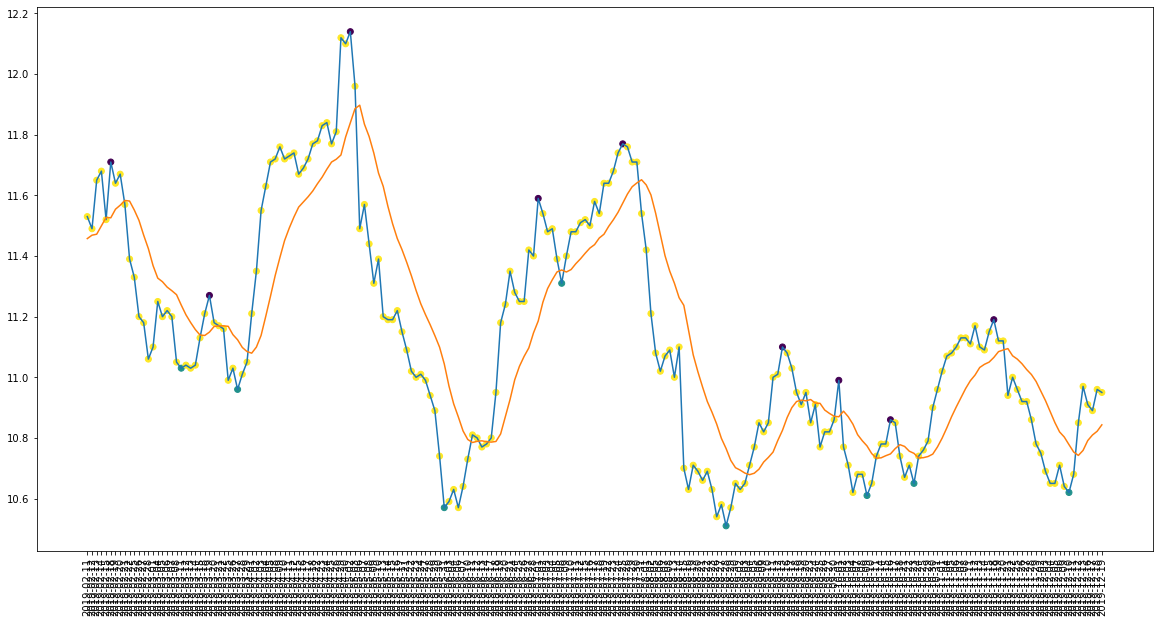

In [190]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [191]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 21
actual holds but predicted sell: 20
actual predicted holds: 160
Percentage buys correct: 50.0%
Percentage sells correct: 0.0%
Percentage holds correct: 79.60199004975124%
actual buys: 8
actual sells: 9
actual holds: 201


In [192]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 60.0%
Percentage sells correct: 65.0%
Percentage holds correct: 86.62790697674419%


In [193]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.329999923706055
Shares owned at the moment: 880
Cash capital at the moment: $2.1814673233020585


Stop Loss Activated!

Share price: $10.989999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9646.78546646118


Share price: $10.960000038146973
Shares owned at the moment: 877
Cash capital at the moment: $8.432652914283608


Price increase from previously bought: 6.641045757711961%
Share price: $11.720000267028807
Shares owned at the moment: 0
Cash capital at the moment: $10258.60717645454


Share price: $10.56999969482422
Shares owned at the moment: 967
Cash capital at the moment: $9.30919987105699


Price increase from previously bought: 6.04706589176931%
Share price: $11.239999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10848.499009150975


Share price: $11.420000076293945
Shares owned at the moment: 947
Cash capital at the moment: $4.018401701920084


Stop Loss Activated!

Share price: $11.079999923706056
Shares owned at t

In [194]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


### recession

In [195]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


In [196]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [197]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(215, 15, 4)

In [198]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [199]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2471 - accuracy: 0.7953 - mean_squared_error: 12.9348 - weighted_accuracy: 0.7953 - weighted_mean_squared_error: 12.9348
Test loss: 0.24712121486663818
Test accuracy: 0.7953488230705261


In [200]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 22, 2: 184, 0: 9})

In [201]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [202]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [203]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,1,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,2,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,2,2


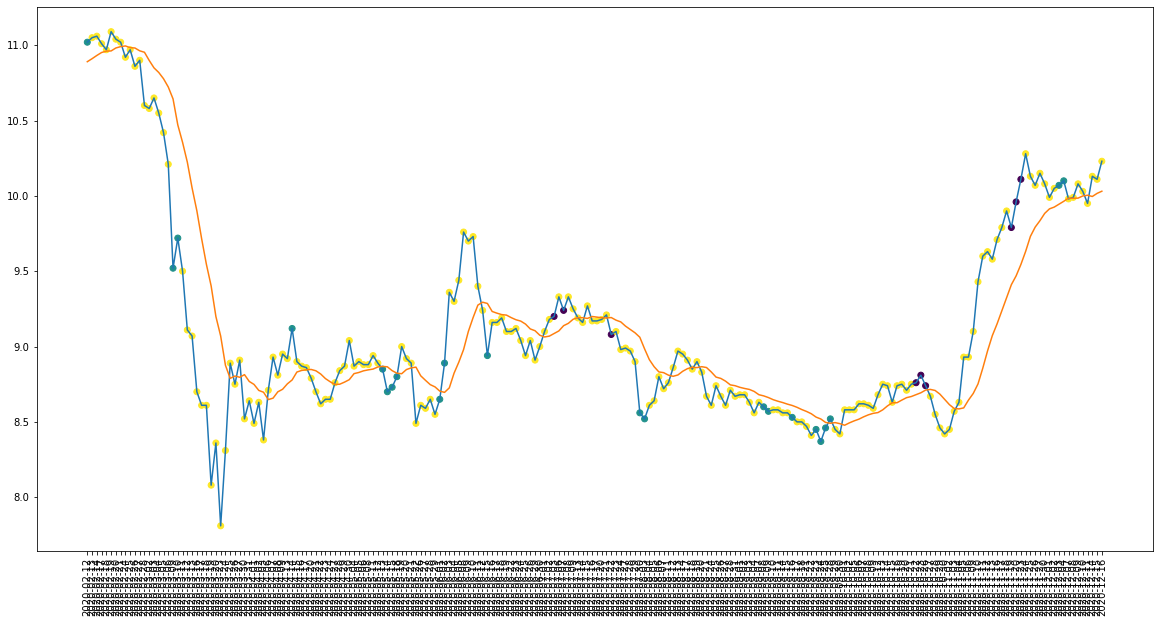

In [204]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

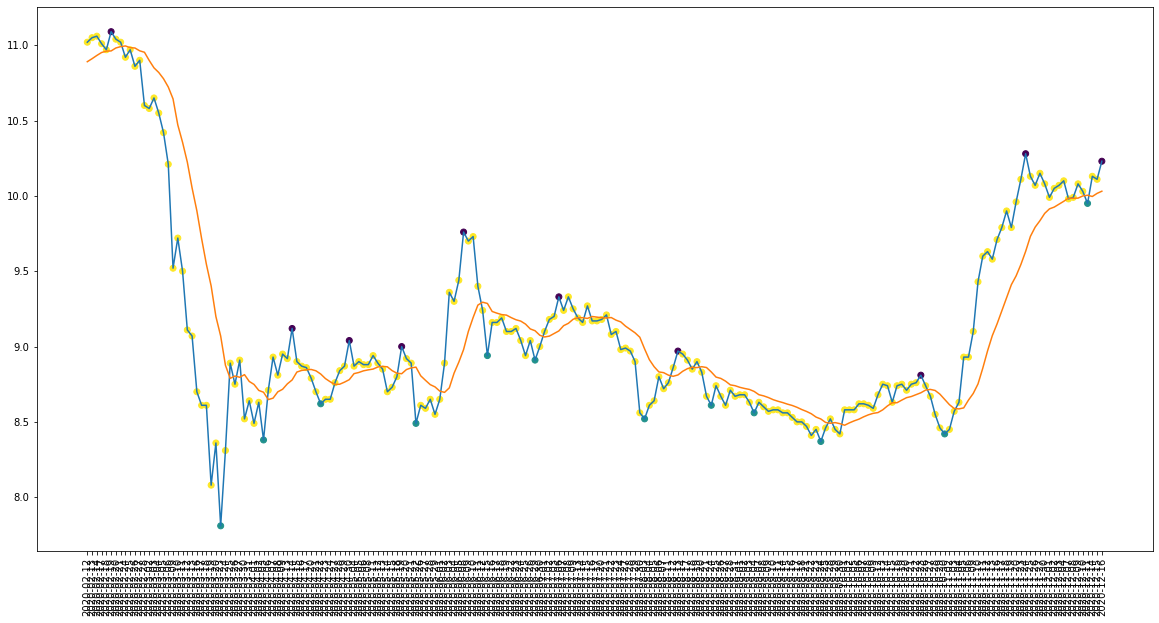

In [205]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [206]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 18
actual holds but predicted sell: 8
actual predicted holds: 167
Percentage buys correct: 25.0%
Percentage sells correct: 10.0%
Percentage holds correct: 86.52849740932642%
actual buys: 12
actual sells: 10
actual holds: 193


In [207]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 59.09090909090909%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 87.43169398907104%


In [208]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.020000457763672
Shares owned at the moment: 904
Cash capital at the moment: $10.523865043640399


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9566.57260894394


Share price: $9.520000457763672
Shares owned at the moment: 1002
Cash capital at the moment: $1.2997890033730073


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9104.416840939999


Share price: $9.119999885559082
Shares owned at the moment: 995
Cash capital at the moment: $5.062355121850487


Stop Loss Activated!

Share price: $8.869999885559082
Shares owned at the moment: 0
Cash capital at the moment: $8806.441704066276


Share price: $8.850000381469727
Shares owned at the moment: 992
Cash capital at the moment: $3.0985246076579642


Stop Loss Activated!

Share price: $8.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8402.017578181267


Share price

In [209]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [6]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


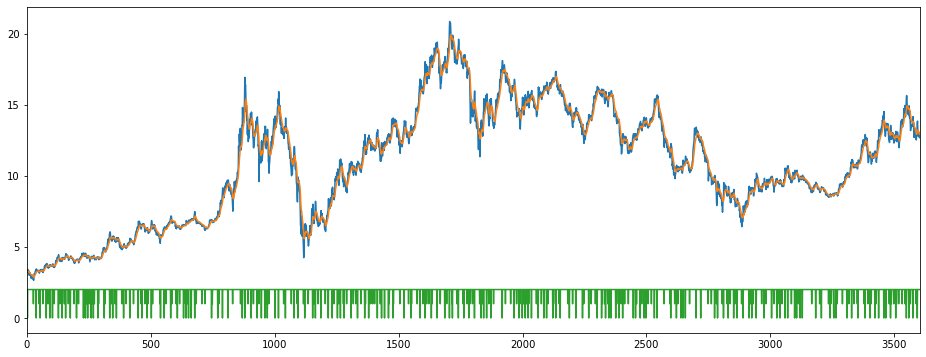

In [7]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [8]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2004-04-07,3.250,3.264699,-57.142857,31539206.0,2.0
2004-04-08,3.200,3.254745,-78.947368,-24878594.0,2.0
2004-04-13,3.250,3.254015,-52.631579,10937473.0,0.0
2004-04-14,3.375,3.272628,-10.416706,98972973.0,2.0
2004-04-15,3.275,3.272993,-52.083331,47190715.0,2.0


In [9]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [10]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(3590, 15, 4)

In [11]:
y = labels
y = np.array(y)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 40ms/step - loss: 0.3027 - accuracy: 0.5181 - mse: 0.4225 - weighted_accuracy: 0.3068 - weighted_mse: 0.5161 - val_loss: 0.3010 - val_accuracy: 0.0501 - val_mse: 0.3502 - val_weighted_accuracy: 0.0501 - val_weighted_mse: 0.3502
Epoch 2/200
23/23 [==============================] - 0s 8ms/step - loss: 0.2219 - accuracy: 0.4325 - mse: 0.6822 - weighted_accuracy: 0.4101 - weighted_mse: 0.6944 - val_loss: 0.2950 - val_accuracy: 0.0446 - val_mse: 0.3703 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3703
Epoch 3/200
23/23 [==============================] - 0s 8ms/step - loss: 0.1950 - accuracy: 0.3175 - mse: 0.9236 - weighted_accuracy: 0.4718 - weighted_mse: 0.8901 - val_loss: 0.2874 - val_accuracy: 0.0446 - val_mse: 0.3972 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3972
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1828 - accuracy: 0.3116 - mse: 1.0658 - weighted_accuracy: 0.5010 - weighte

Epoch 30/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1334 - accuracy: 0.3900 - mse: 1.6706 - weighted_accuracy: 0.7255 - weighted_mse: 1.5929 - val_loss: 0.1687 - val_accuracy: 0.4986 - val_mse: 1.4516 - val_weighted_accuracy: 0.4986 - val_weighted_mse: 1.4516
Epoch 31/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1315 - accuracy: 0.4210 - mse: 1.6527 - weighted_accuracy: 0.7417 - weighted_mse: 1.5770 - val_loss: 0.1684 - val_accuracy: 0.5028 - val_mse: 1.4875 - val_weighted_accuracy: 0.5028 - val_weighted_mse: 1.4875
Epoch 32/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1309 - accuracy: 0.4335 - mse: 1.6881 - weighted_accuracy: 0.7343 - weighted_mse: 1.6209 - val_loss: 0.1727 - val_accuracy: 0.4554 - val_mse: 1.5175 - val_weighted_accuracy: 0.4554 - val_weighted_mse: 1.5175
Epoch 33/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1301 - accuracy: 0.3834 - mse: 1.7296 - weighted_accuracy: 0.7352 - weig

Epoch 59/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1082 - accuracy: 0.5550 - mse: 2.1597 - weighted_accuracy: 0.8199 - weighted_mse: 2.1613 - val_loss: 0.1669 - val_accuracy: 0.5501 - val_mse: 2.1356 - val_weighted_accuracy: 0.5501 - val_weighted_mse: 2.1356
Epoch 60/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1069 - accuracy: 0.5978 - mse: 2.1670 - weighted_accuracy: 0.8332 - weighted_mse: 2.1893 - val_loss: 0.1710 - val_accuracy: 0.5237 - val_mse: 2.1746 - val_weighted_accuracy: 0.5237 - val_weighted_mse: 2.1746
Epoch 61/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1065 - accuracy: 0.5843 - mse: 2.1868 - weighted_accuracy: 0.8306 - weighted_mse: 2.2093 - val_loss: 0.1682 - val_accuracy: 0.5376 - val_mse: 2.1819 - val_weighted_accuracy: 0.5376 - val_weighted_mse: 2.1819
Epoch 62/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1063 - accuracy: 0.5999 - mse: 2.2209 - weighted_accuracy: 0.8197 - weig

Epoch 88/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0877 - accuracy: 0.6908 - mse: 2.8340 - weighted_accuracy: 0.8721 - weighted_mse: 2.9207 - val_loss: 0.1588 - val_accuracy: 0.6170 - val_mse: 2.9121 - val_weighted_accuracy: 0.6170 - val_weighted_mse: 2.9121
Epoch 89/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0867 - accuracy: 0.7040 - mse: 2.8079 - weighted_accuracy: 0.8818 - weighted_mse: 2.9045 - val_loss: 0.1531 - val_accuracy: 0.6448 - val_mse: 2.8245 - val_weighted_accuracy: 0.6448 - val_weighted_mse: 2.8245
Epoch 90/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0847 - accuracy: 0.7326 - mse: 2.8224 - weighted_accuracy: 0.8899 - weighted_mse: 2.9440 - val_loss: 0.1680 - val_accuracy: 0.5766 - val_mse: 3.0034 - val_weighted_accuracy: 0.5766 - val_weighted_mse: 3.0034
Epoch 91/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0884 - accuracy: 0.6762 - mse: 2.8924 - weighted_accuracy: 0.8668 - weig

Epoch 117/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0691 - accuracy: 0.7719 - mse: 3.6829 - weighted_accuracy: 0.9092 - weighted_mse: 3.8045 - val_loss: 0.1400 - val_accuracy: 0.7423 - val_mse: 3.9022 - val_weighted_accuracy: 0.7423 - val_weighted_mse: 3.9022
Epoch 118/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0688 - accuracy: 0.7852 - mse: 3.7181 - weighted_accuracy: 0.9115 - weighted_mse: 3.7977 - val_loss: 0.1555 - val_accuracy: 0.6769 - val_mse: 3.8599 - val_weighted_accuracy: 0.6769 - val_weighted_mse: 3.8599
Epoch 119/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0676 - accuracy: 0.7810 - mse: 3.7548 - weighted_accuracy: 0.9124 - weighted_mse: 3.8850 - val_loss: 0.1634 - val_accuracy: 0.6532 - val_mse: 3.7624 - val_weighted_accuracy: 0.6532 - val_weighted_mse: 3.7624
Epoch 120/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0641 - accuracy: 0.8085 - mse: 3.8141 - weighted_accuracy: 0.9250 - 

Epoch 146/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.8325 - mse: 4.8543 - weighted_accuracy: 0.9290 - weighted_mse: 4.9958 - val_loss: 0.1634 - val_accuracy: 0.7103 - val_mse: 5.4154 - val_weighted_accuracy: 0.7103 - val_weighted_mse: 5.4154
Epoch 147/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.8499 - mse: 4.9632 - weighted_accuracy: 0.9376 - weighted_mse: 5.0066 - val_loss: 0.1815 - val_accuracy: 0.6713 - val_mse: 5.0081 - val_weighted_accuracy: 0.6713 - val_weighted_mse: 5.0081
Epoch 148/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0537 - accuracy: 0.8437 - mse: 4.9701 - weighted_accuracy: 0.9306 - weighted_mse: 5.0184 - val_loss: 0.1777 - val_accuracy: 0.6616 - val_mse: 4.7951 - val_weighted_accuracy: 0.6616 - val_weighted_mse: 4.7951
Epoch 149/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0526 - accuracy: 0.8437 - mse: 4.9467 - weighted_accuracy: 0.9379 - 

Epoch 175/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0467 - accuracy: 0.8625 - mse: 6.2605 - weighted_accuracy: 0.9399 - weighted_mse: 6.2373 - val_loss: 0.1623 - val_accuracy: 0.7702 - val_mse: 6.3754 - val_weighted_accuracy: 0.7702 - val_weighted_mse: 6.3754
Epoch 176/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.8893 - mse: 6.2168 - weighted_accuracy: 0.9570 - weighted_mse: 6.1700 - val_loss: 0.1561 - val_accuracy: 0.7827 - val_mse: 6.7458 - val_weighted_accuracy: 0.7827 - val_weighted_mse: 6.7458
Epoch 177/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0392 - accuracy: 0.8889 - mse: 6.3765 - weighted_accuracy: 0.9544 - weighted_mse: 6.3049 - val_loss: 0.1575 - val_accuracy: 0.7925 - val_mse: 6.7108 - val_weighted_accuracy: 0.7925 - val_weighted_mse: 6.7108
Epoch 178/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0391 - accuracy: 0.9025 - mse: 6.4226 - weighted_accuracy: 0.9618 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1808696687221527
Test accuracy: 0.7743732333183289


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.47915    -4.992833    0.82197016]
 [ 0.02935069 -2.3416486  -1.4123852 ]
 [-4.55901    -2.222071    1.9354086 ]
 ...
 [-4.598704   -1.0097368   0.217949  ]
 [-2.0520618  -3.6179798   1.2344736 ]
 [-0.839116   -2.6033988   0.6038781 ]]


Counter({2: 611, 0: 62, 1: 45})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 718
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 30
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 30
actual holds but predicted buy: 43
actual holds but predicted sell: 59
actual predicted holds: 551
Percentage buys correct: 6.25%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 84.37978560490046%
actual buys: 32
actual sells: 33
actual holds: 653


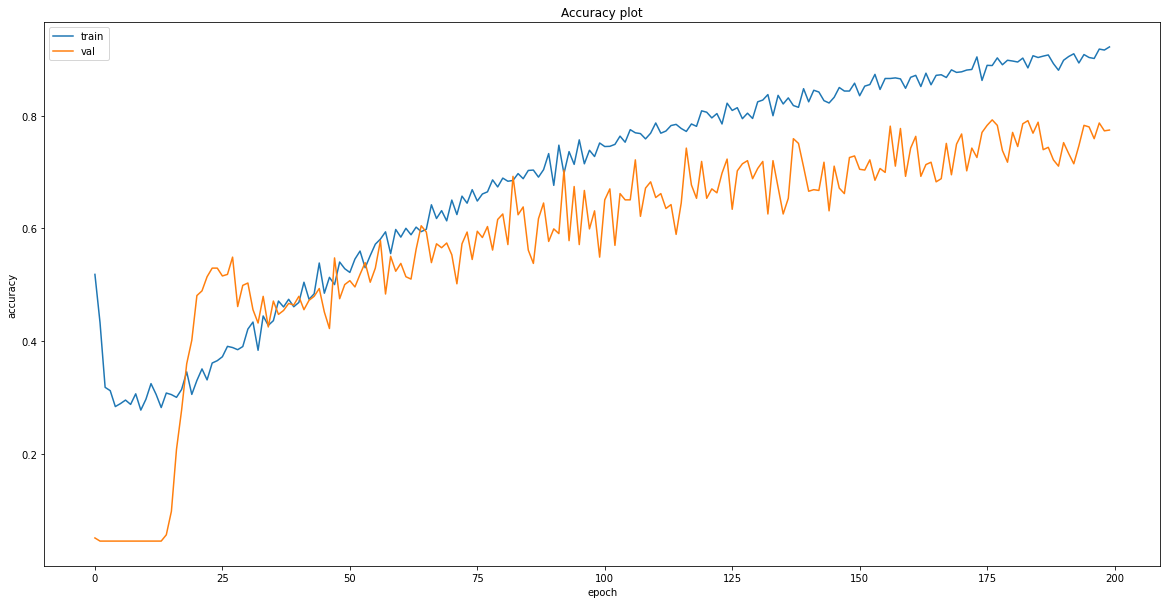

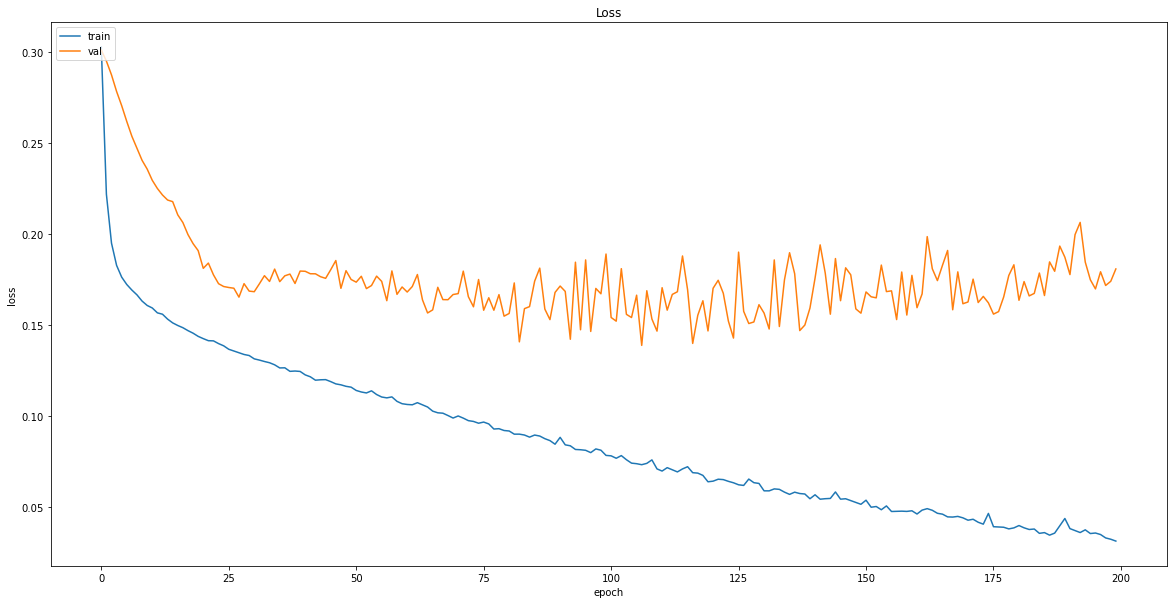

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_original.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [23]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [24]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(211, 15, 4)

In [25]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [26]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1578 - accuracy: 0.7867 - mean_squared_error: 7.7676 - weighted_accuracy: 0.7867 - weighted_mean_squared_error: 7.7676
Test loss: 0.15779531002044678
Test accuracy: 0.7867298722267151


In [27]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 179, 0: 19, 1: 13})

In [28]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [29]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [30]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,2,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,0,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,0,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,0,2


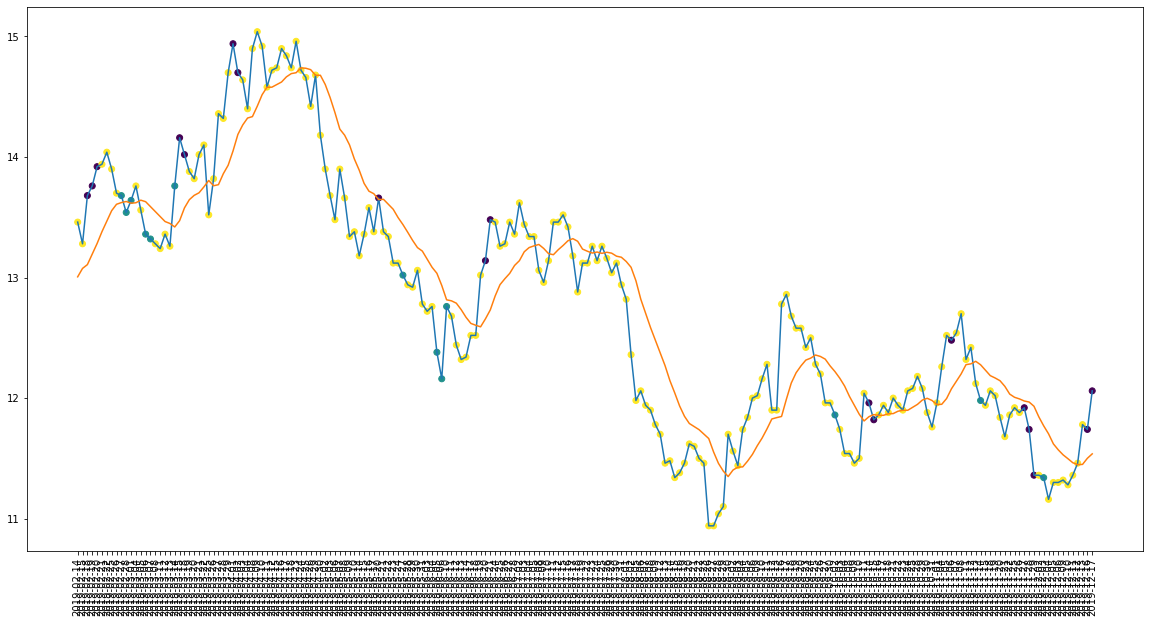

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

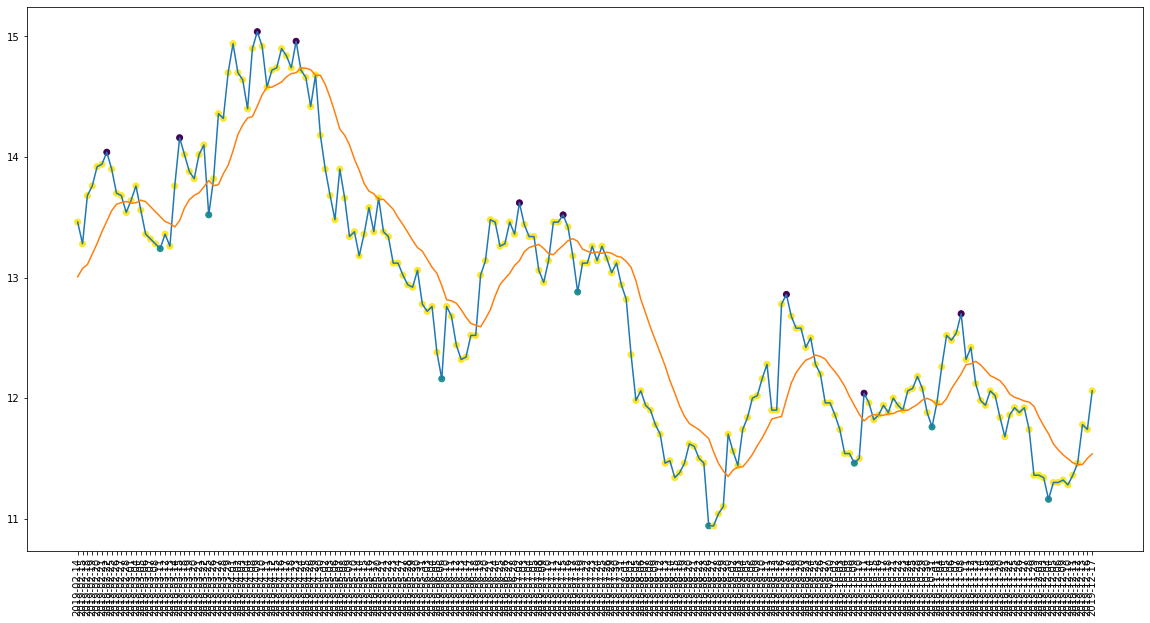

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 12
actual holds but predicted sell: 18
actual predicted holds: 164
Percentage buys correct: 12.5%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 84.5360824742268%
actual buys: 8
actual sells: 9
actual holds: 194


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 61.53846153846154%
Percentage sells correct: 66.66666666666667%
Percentage holds correct: 83.79888268156425%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.760000228881836
Shares owned at the moment: 699
Cash capital at the moment: $10.135342930319894


Price increase from previously bought: 8.277812555251597%
Share price: $14.9399995803833
Shares owned at the moment: 0
Cash capital at the moment: $10424.476635424855


Share price: $13.020000457763672
Shares owned at the moment: 798
Cash capital at the moment: $5.943879124881278


Stop Loss Activated!

Share price: $12.380000114440918
Shares owned at the moment: 0
Cash capital at the moment: $9858.016060197593


Share price: $12.380000114440918
Shares owned at the moment: 794
Cash capital at the moment: $1.2642390816217812


Price increase from previously bought: 5.847853957806537%
Share price: $13.140000343322756
Shares owned a

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [37]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [38]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(213, 15, 4)

In [39]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [40]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1654 - accuracy: 0.7746 - mean_squared_error: 7.3403 - weighted_accuracy: 0.7746 - weighted_mean_squared_error: 7.3403
Test loss: 0.1653873473405838
Test accuracy: 0.7746478915214539


In [41]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 1: 17, 0: 22})

In [42]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [43]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [44]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


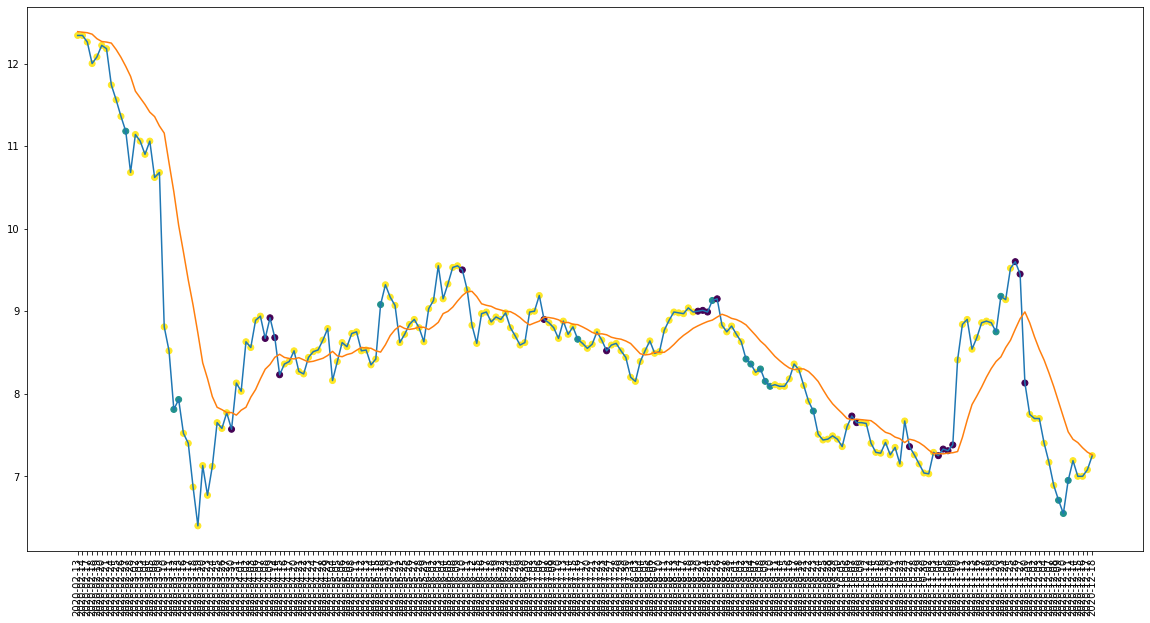

In [45]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

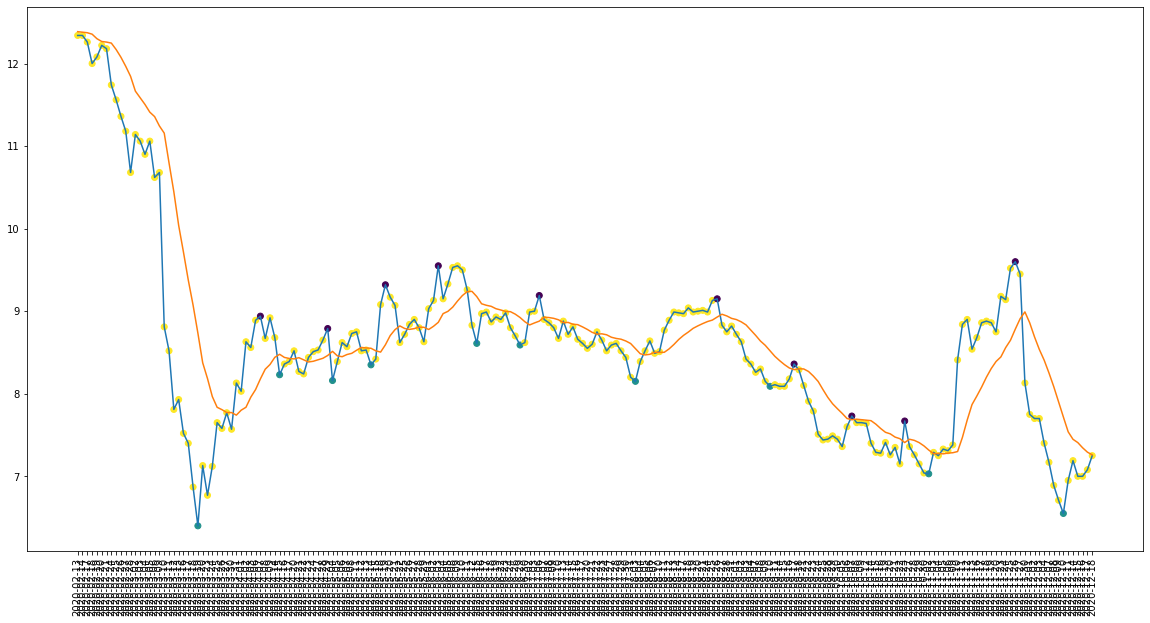

In [46]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [47]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 15
actual holds but predicted sell: 18
actual predicted holds: 160
Percentage buys correct: 20.0%
Percentage sells correct: 30.0%
Percentage holds correct: 82.90155440414507%
actual buys: 10
actual sells: 10
actual holds: 193


In [48]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 41.1764705882353%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 82.08092485549133%


In [49]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.18000030517578
Shares owned at the moment: 892
Cash capital at the moment: $0.015187034608970862


Stop Loss Activated!

Share price: $10.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9500.377418502807


Share price: $7.809999942779541
Shares owned at the moment: 1213
Cash capital at the moment: $0.7952806020966818


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $9097.470417529581


Share price: $9.079999923706056
Shares owned at the moment: 999
Cash capital at the moment: $1.6054639568283164


Stop Loss Activated!

Share price: $8.619999885559082
Shares owned at the moment: 0
Cash capital at the moment: $8589.304054944749


Share price: $8.659999847412111
Shares owned at the moment: 989
Cash capital at the moment: $1.011171269170518


Stop Loss Activated!

Share price: $8.199999809265138
Shares owned at the moment: 0
Cash capital at the moment: $8088.509033151144


Share pric

In [50]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [51]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


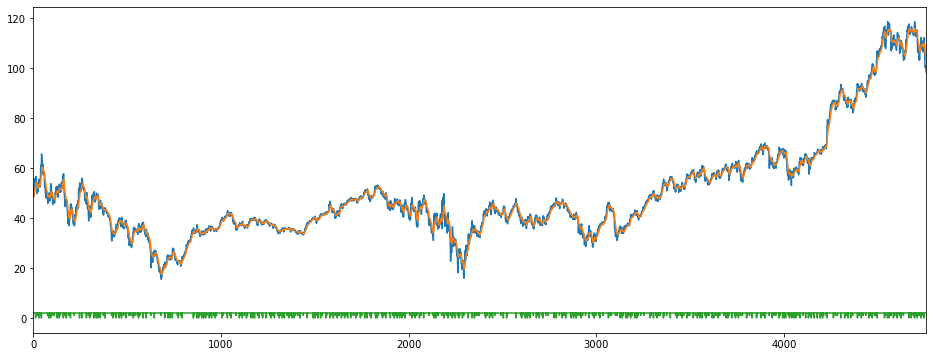

In [52]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [54]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(4745, 15, 4)

In [55]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [56]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [57]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [59]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2933 - accuracy: 0.4739 - mse: 0.4764 - weighted_accuracy: 0.3122 - weighted_mse: 0.5405 - val_loss: 0.2998 - val_accuracy: 0.0464 - val_mse: 0.3545 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3545
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2100 - accuracy: 0.3617 - mse: 0.7986 - weighted_accuracy: 0.4383 - weighted_mse: 0.7762 - val_loss: 0.2911 - val_accuracy: 0.0453 - val_mse: 0.3855 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3855
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1892 - accuracy: 0.2906 - mse: 1.0356 - weighted_accuracy: 0.4829 - weighted_mse: 1.0000 - val_loss: 0.2802 - val_accuracy: 0.0453 - val_mse: 0.4268 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4268
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1810 - accuracy: 0.2626 - mse: 1.1820 - weighted_accuracy: 0.4988 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1328 - accuracy: 0.4154 - mse: 1.7709 - weighted_accuracy: 0.7254 - weighted_mse: 1.6809 - val_loss: 0.1805 - val_accuracy: 0.4299 - val_mse: 1.6723 - val_weighted_accuracy: 0.4299 - val_weighted_mse: 1.6723
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1324 - accuracy: 0.4339 - mse: 1.7744 - weighted_accuracy: 0.7284 - weighted_mse: 1.6926 - val_loss: 0.2006 - val_accuracy: 0.3140 - val_mse: 1.8392 - val_weighted_accuracy: 0.3140 - val_weighted_mse: 1.8392
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1309 - accuracy: 0.4283 - mse: 1.7948 - weighted_accuracy: 0.7396 - weighted_mse: 1.7174 - val_loss: 0.1891 - val_accuracy: 0.3888 - val_mse: 1.8143 - val_weighted_accuracy: 0.3888 - val_weighted_mse: 1.8143
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1303 - accuracy: 0.4407 - mse: 1.8017 - weighted_accuracy: 0.7498 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1058 - accuracy: 0.6172 - mse: 2.3047 - weighted_accuracy: 0.8315 - weighted_mse: 2.2808 - val_loss: 0.1750 - val_accuracy: 0.5184 - val_mse: 2.4177 - val_weighted_accuracy: 0.5184 - val_weighted_mse: 2.4177
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1058 - accuracy: 0.6193 - mse: 2.3196 - weighted_accuracy: 0.8303 - weighted_mse: 2.2989 - val_loss: 0.1758 - val_accuracy: 0.5279 - val_mse: 2.4746 - val_weighted_accuracy: 0.5279 - val_weighted_mse: 2.4746
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1051 - accuracy: 0.6075 - mse: 2.3243 - weighted_accuracy: 0.8280 - weighted_mse: 2.2987 - val_loss: 0.1832 - val_accuracy: 0.5121 - val_mse: 2.4913 - val_weighted_accuracy: 0.5121 - val_weighted_mse: 2.4913
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1037 - accuracy: 0.5998 - mse: 2.3778 - weighted_accuracy: 0.8233 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0820 - accuracy: 0.7239 - mse: 3.1607 - weighted_accuracy: 0.8838 - weighted_mse: 3.1531 - val_loss: 0.1663 - val_accuracy: 0.6228 - val_mse: 3.2810 - val_weighted_accuracy: 0.6228 - val_weighted_mse: 3.2810
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0788 - accuracy: 0.7410 - mse: 3.1900 - weighted_accuracy: 0.8919 - weighted_mse: 3.1948 - val_loss: 0.1582 - val_accuracy: 0.6470 - val_mse: 3.3723 - val_weighted_accuracy: 0.6470 - val_weighted_mse: 3.3723
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0798 - accuracy: 0.7244 - mse: 3.2932 - weighted_accuracy: 0.8878 - weighted_mse: 3.3003 - val_loss: 0.1728 - val_accuracy: 0.5890 - val_mse: 3.4173 - val_weighted_accuracy: 0.5890 - val_weighted_mse: 3.4173
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0794 - accuracy: 0.7418 - mse: 3.2520 - weighted_accuracy: 0.8942 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.8130 - mse: 4.4312 - weighted_accuracy: 0.9222 - weighted_mse: 4.2975 - val_loss: 0.1994 - val_accuracy: 0.5975 - val_mse: 4.6943 - val_weighted_accuracy: 0.5975 - val_weighted_mse: 4.6943
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0610 - accuracy: 0.8043 - mse: 4.6258 - weighted_accuracy: 0.9227 - weighted_mse: 4.5206 - val_loss: 0.1839 - val_accuracy: 0.6459 - val_mse: 5.0085 - val_weighted_accuracy: 0.6459 - val_weighted_mse: 5.0085
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.8243 - mse: 4.5979 - weighted_accuracy: 0.9358 - weighted_mse: 4.4681 - val_loss: 0.1605 - val_accuracy: 0.7144 - val_mse: 4.9691 - val_weighted_accuracy: 0.7144 - val_weighted_mse: 4.9691
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0563 - accuracy: 0.8296 - mse: 4.6216 - weighted_accuracy: 0.9338 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0435 - accuracy: 0.8780 - mse: 6.2934 - weighted_accuracy: 0.9536 - weighted_mse: 5.9454 - val_loss: 0.1974 - val_accuracy: 0.6913 - val_mse: 6.5222 - val_weighted_accuracy: 0.6913 - val_weighted_mse: 6.5222
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0448 - accuracy: 0.8678 - mse: 6.4169 - weighted_accuracy: 0.9498 - weighted_mse: 6.0725 - val_loss: 0.1924 - val_accuracy: 0.7028 - val_mse: 6.9346 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 6.9346
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.8851 - mse: 6.5411 - weighted_accuracy: 0.9542 - weighted_mse: 6.0858 - val_loss: 0.1961 - val_accuracy: 0.6986 - val_mse: 6.9316 - val_weighted_accuracy: 0.6986 - val_weighted_mse: 6.9316
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0466 - accuracy: 0.8717 - mse: 6.4986 - weighted_accuracy: 0.9473 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0313 - accuracy: 0.9191 - mse: 8.4509 - weighted_accuracy: 0.9704 - weighted_mse: 7.6929 - val_loss: 0.2127 - val_accuracy: 0.7155 - val_mse: 8.4530 - val_weighted_accuracy: 0.7155 - val_weighted_mse: 8.4530
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0334 - accuracy: 0.9141 - mse: 8.5090 - weighted_accuracy: 0.9667 - weighted_mse: 7.6920 - val_loss: 0.1938 - val_accuracy: 0.7640 - val_mse: 9.2199 - val_weighted_accuracy: 0.7640 - val_weighted_mse: 9.2199
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0335 - accuracy: 0.9178 - mse: 8.5663 - weighted_accuracy: 0.9700 - weighted_mse: 7.7297 - val_loss: 0.2126 - val_accuracy: 0.7218 - val_mse: 8.8246 - val_weighted_accuracy: 0.7218 - val_weighted_mse: 8.8246
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9128 - mse: 8.5692 - weighted_accuracy: 0.9626 - 

In [60]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21179072558879852
Test accuracy: 0.7586933374404907


In [61]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.4841573  -4.535359    2.1868467 ]
 [-3.7704012  -3.5554862   1.8693953 ]
 [-3.1953635  -6.163817    2.1377742 ]
 ...
 [-0.60240734 -3.4122622   0.27125326]
 [-0.54303837 -4.700912    0.34743777]
 [-1.5647528  -4.115282    1.090835  ]]


Counter({2: 789, 0: 61, 1: 99})

In [62]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [63]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 37
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 39
actual holds but predicted buy: 94
actual holds but predicted sell: 58
actual predicted holds: 713
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 82.42774566473989%
actual buys: 43
actual sells: 41
actual holds: 865


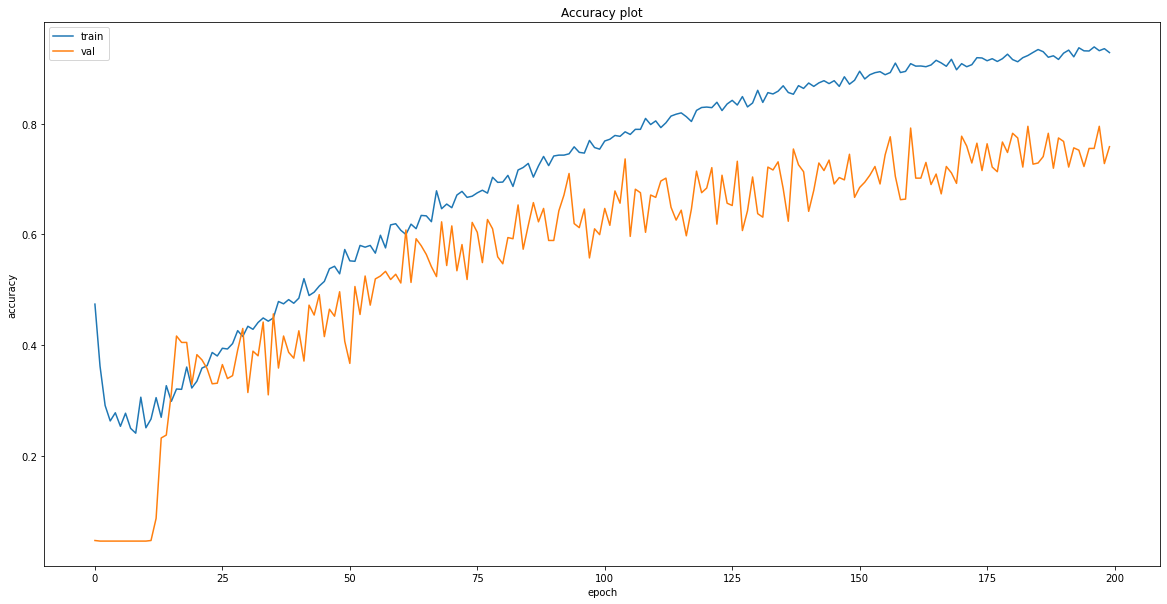

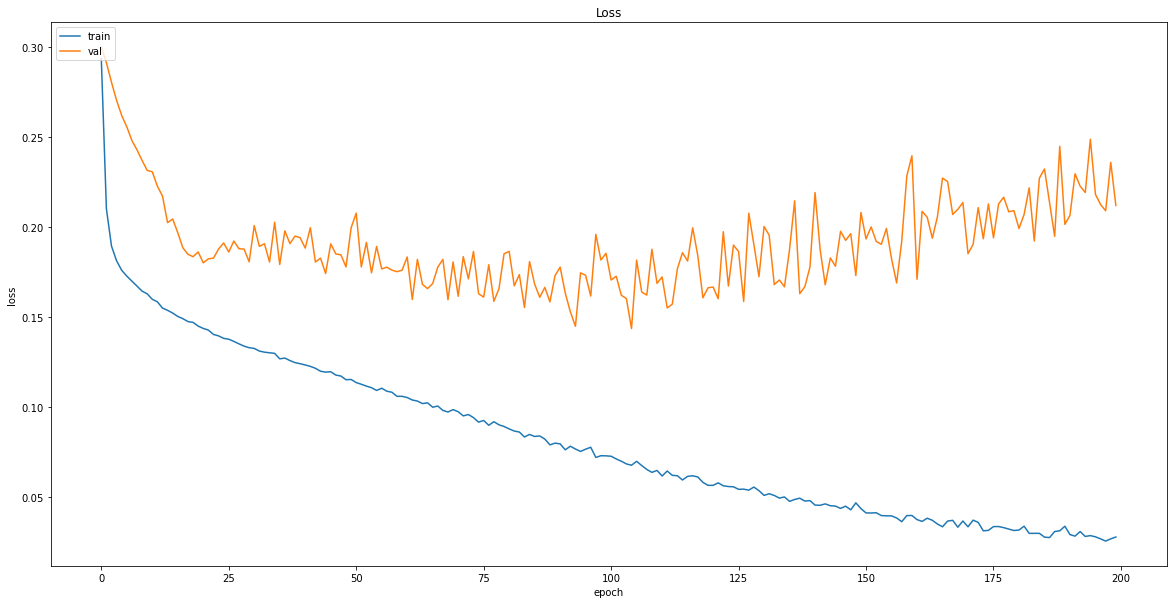

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [66]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [67]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [68]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [69]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1789 - accuracy: 0.7936 - mean_squared_error: 11.2644 - weighted_accuracy: 0.7936 - weighted_mean_squared_error: 11.2644
Test loss: 0.1789436936378479
Test accuracy: 0.7935779690742493


In [70]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 182, 1: 16, 0: 20})

In [71]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [72]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [73]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,2,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,1,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,1,2


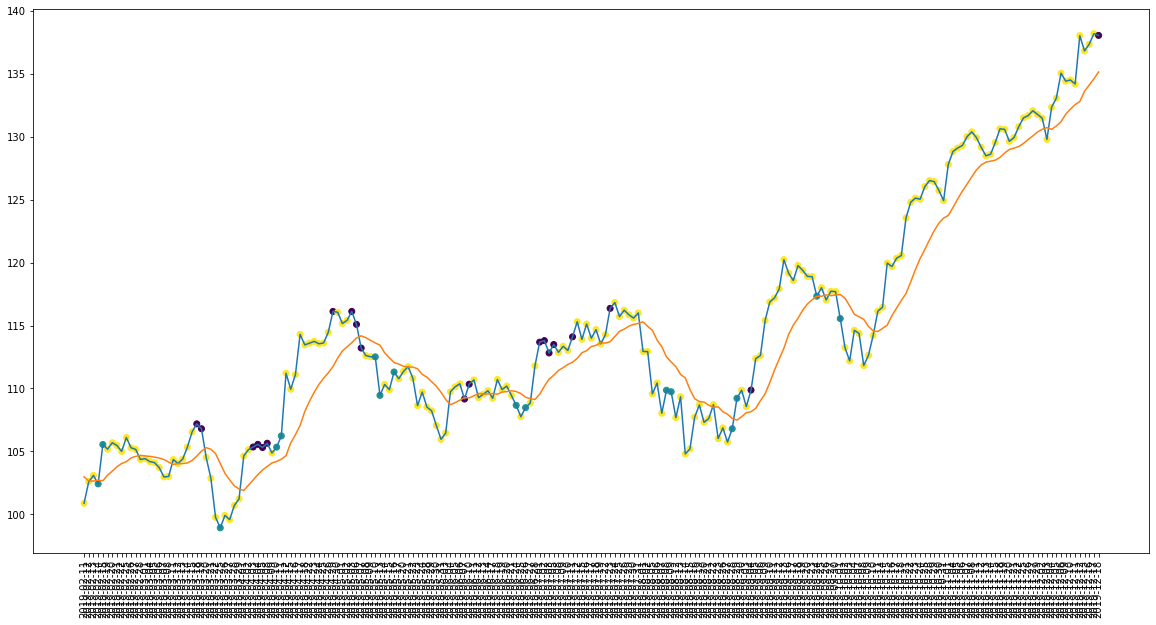

In [74]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

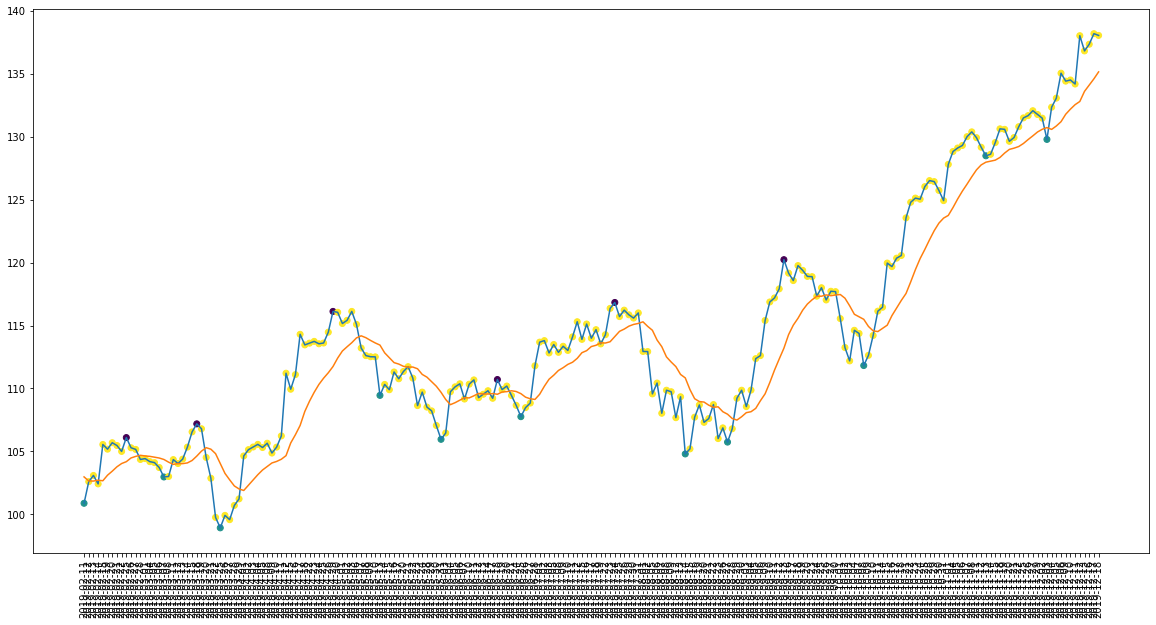

In [75]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [76]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 14
actual holds but predicted sell: 18
actual predicted holds: 169
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 84.07960199004975%
actual buys: 11
actual sells: 6
actual holds: 201


In [77]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 50.0%
Percentage sells correct: 70.0%
Percentage holds correct: 86.74033149171271%


In [78]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $102.41999816894531
Shares owned at the moment: 97
Cash capital at the moment: $37.93964310073898


Stop Loss Activated!

Share price: $98.93000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9607.760095121384


Share price: $98.93000030517578
Shares owned at the moment: 96
Cash capital at the moment: $84.36254574394297


Price increase from previously bought: 6.197392276003066%
Share price: $105.3499984741211
Shares owned at the moment: 0
Cash capital at the moment: $10170.149999662399


Share price: $105.33999633789062
Shares owned at the moment: 96
Cash capital at the moment: $29.70059219169525


Price increase from previously bought: 9.931225094020402%
Share price: $116.12000274658205
Shares owned at the moment: 0
Cash capital at the moment: $11146.565175138474


Share price: $112.51000213623048
Shares owned at the moment: 98
Cash capital at the moment: $90.26352021217099


Stop Loss Activated!

Share price: $108.63999938964844
Shares owned at the 

In [79]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [80]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [81]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [82]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [83]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2711 - accuracy: 0.6758 - mean_squared_error: 9.9262 - weighted_accuracy: 0.6758 - weighted_mean_squared_error: 9.9262
Test loss: 0.2711177170276642
Test accuracy: 0.6757990717887878


In [84]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 162, 0: 20, 1: 37})

In [85]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [86]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [87]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,2,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,0,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,1,2


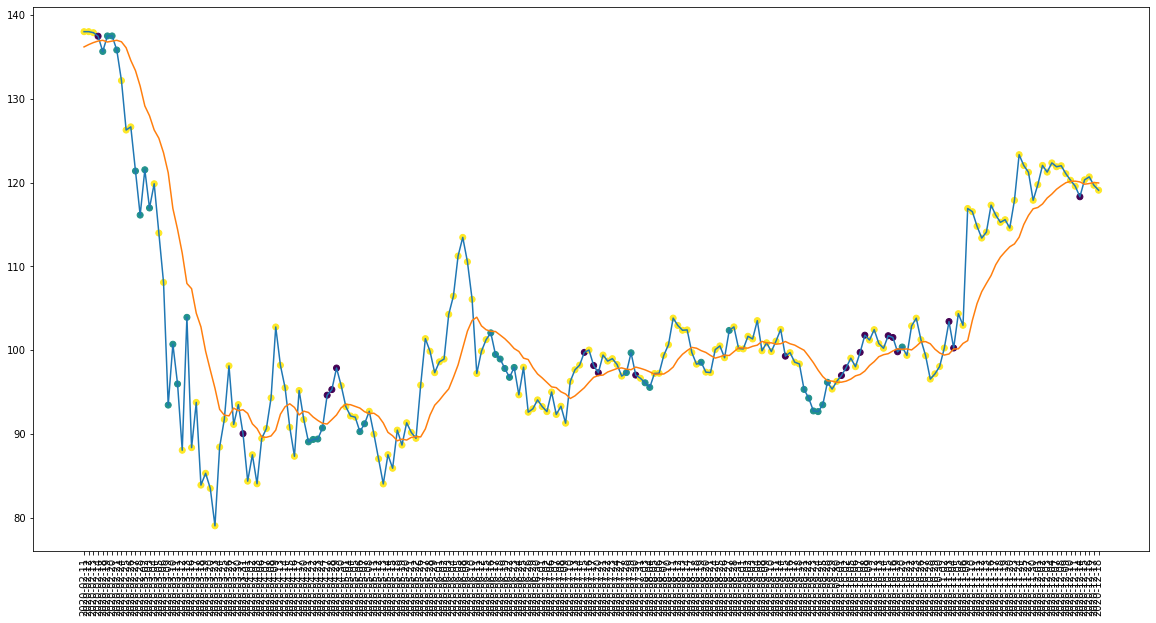

In [88]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

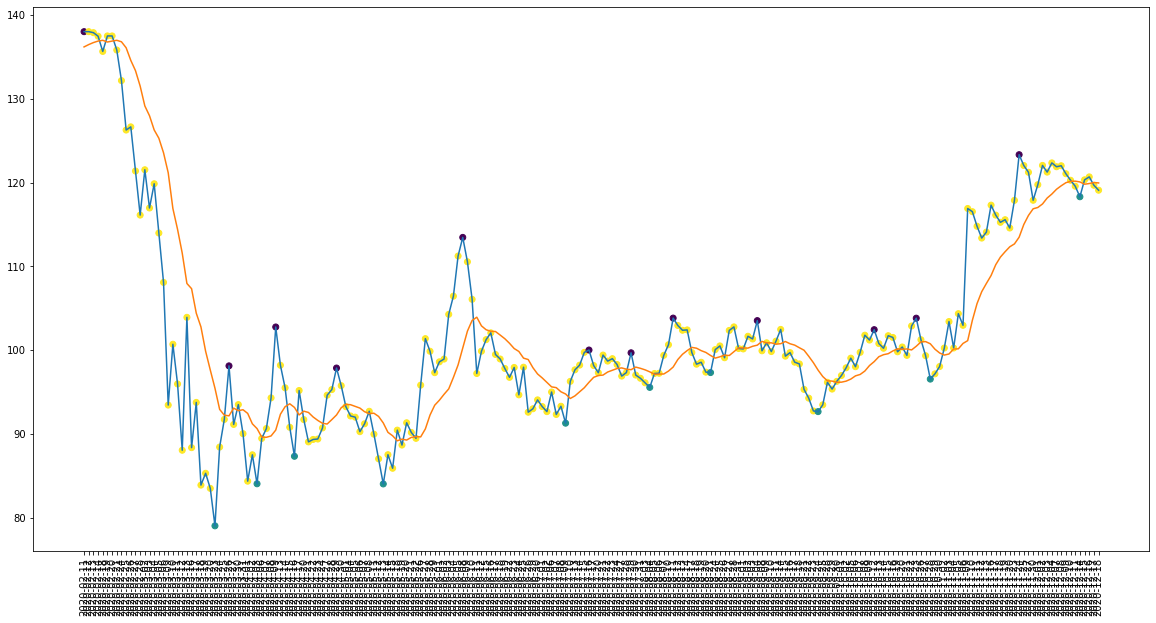

In [89]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [90]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 34
actual holds but predicted sell: 18
actual predicted holds: 145
Percentage buys correct: 20.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 73.60406091370558%
actual buys: 10
actual sells: 12
actual holds: 197


In [91]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 51.351351351351354%
Percentage sells correct: 45.0%
Percentage holds correct: 80.74534161490683%


In [92]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $135.63999938964844
Shares owned at the moment: 73
Cash capital at the moment: $71.05031467819208


Stop Loss Activated!

Share price: $126.26000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9262.68377519417


Share price: $121.37000274658205
Shares owned at the moment: 76
Cash capital at the moment: $13.197235879897562


Stop Loss Activated!

Share price: $116.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $8813.290292139052


Share price: $116.11000061035156
Shares owned at the moment: 75
Cash capital at the moment: $81.09255873680013


Stop Loss Activated!

Share price: $108.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $8164.8011956882465


Share price: $93.44000244140624
Shares owned at the moment: 87
Cash capital at the moment: $13.165462701796969


Stop Loss Activated!

Share price: $88.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $7652.449764974594


Share price:

In [93]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


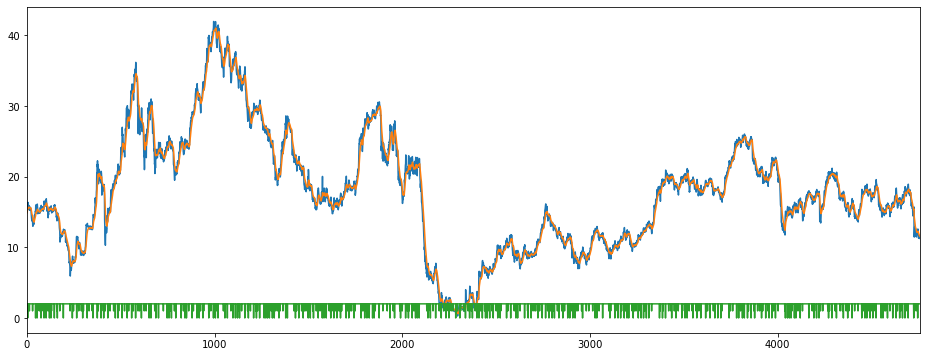

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(4745, 15, 4)

In [9]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [10]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [11]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [121]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [122]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2923 - accuracy: 0.5032 - mse: 0.4630 - weighted_accuracy: 0.3271 - weighted_mse: 0.5407 - val_loss: 0.2996 - val_accuracy: 0.0464 - val_mse: 0.3549 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3549
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2086 - accuracy: 0.2982 - mse: 0.8247 - weighted_accuracy: 0.4141 - weighted_mse: 0.7992 - val_loss: 0.2908 - val_accuracy: 0.0464 - val_mse: 0.3873 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3873
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1886 - accuracy: 0.2595 - mse: 1.0531 - weighted_accuracy: 0.4820 - weighted_mse: 1.0143 - val_loss: 0.2794 - val_accuracy: 0.0464 - val_mse: 0.4283 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4283
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1810 - accuracy: 0.2568 - mse: 1.1843 - weighted_accuracy: 0.5194 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1366 - accuracy: 0.3912 - mse: 1.6560 - weighted_accuracy: 0.7128 - weighted_mse: 1.5710 - val_loss: 0.1971 - val_accuracy: 0.3330 - val_mse: 1.6784 - val_weighted_accuracy: 0.3330 - val_weighted_mse: 1.6784
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1357 - accuracy: 0.4349 - mse: 1.6479 - weighted_accuracy: 0.7252 - weighted_mse: 1.5753 - val_loss: 0.1897 - val_accuracy: 0.3783 - val_mse: 1.6850 - val_weighted_accuracy: 0.3783 - val_weighted_mse: 1.6850
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1339 - accuracy: 0.3886 - mse: 1.7135 - weighted_accuracy: 0.7136 - weighted_mse: 1.6234 - val_loss: 0.1771 - val_accuracy: 0.4721 - val_mse: 1.6875 - val_weighted_accuracy: 0.4721 - val_weighted_mse: 1.6875
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1338 - accuracy: 0.4120 - mse: 1.7167 - weighted_accuracy: 0.7259 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1128 - accuracy: 0.5416 - mse: 2.2384 - weighted_accuracy: 0.7954 - weighted_mse: 2.2171 - val_loss: 0.1782 - val_accuracy: 0.4974 - val_mse: 2.3253 - val_weighted_accuracy: 0.4974 - val_weighted_mse: 2.3253
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1111 - accuracy: 0.5319 - mse: 2.2712 - weighted_accuracy: 0.7972 - weighted_mse: 2.2612 - val_loss: 0.1907 - val_accuracy: 0.4320 - val_mse: 2.4373 - val_weighted_accuracy: 0.4320 - val_weighted_mse: 2.4373
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1101 - accuracy: 0.5764 - mse: 2.3158 - weighted_accuracy: 0.8191 - weighted_mse: 2.2976 - val_loss: 0.1786 - val_accuracy: 0.5016 - val_mse: 2.3774 - val_weighted_accuracy: 0.5016 - val_weighted_mse: 2.3774
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1089 - accuracy: 0.5609 - mse: 2.3553 - weighted_accuracy: 0.8079 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0899 - accuracy: 0.6884 - mse: 3.0296 - weighted_accuracy: 0.8729 - weighted_mse: 3.0828 - val_loss: 0.1939 - val_accuracy: 0.5564 - val_mse: 3.1028 - val_weighted_accuracy: 0.5564 - val_weighted_mse: 3.1028
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0895 - accuracy: 0.6844 - mse: 3.0587 - weighted_accuracy: 0.8642 - weighted_mse: 3.1017 - val_loss: 0.2025 - val_accuracy: 0.5153 - val_mse: 3.1404 - val_weighted_accuracy: 0.5153 - val_weighted_mse: 3.1404
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0875 - accuracy: 0.6770 - mse: 3.1361 - weighted_accuracy: 0.8651 - weighted_mse: 3.2135 - val_loss: 0.1876 - val_accuracy: 0.5448 - val_mse: 3.2059 - val_weighted_accuracy: 0.5448 - val_weighted_mse: 3.2059
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0880 - accuracy: 0.6841 - mse: 3.1488 - weighted_accuracy: 0.8659 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0686 - accuracy: 0.7713 - mse: 4.1316 - weighted_accuracy: 0.9106 - weighted_mse: 4.2158 - val_loss: 0.1850 - val_accuracy: 0.6417 - val_mse: 4.5622 - val_weighted_accuracy: 0.6417 - val_weighted_mse: 4.5622
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0700 - accuracy: 0.7771 - mse: 4.2643 - weighted_accuracy: 0.9128 - weighted_mse: 4.3020 - val_loss: 0.1726 - val_accuracy: 0.6733 - val_mse: 4.6303 - val_weighted_accuracy: 0.6733 - val_weighted_mse: 4.6303
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0685 - accuracy: 0.7821 - mse: 4.3570 - weighted_accuracy: 0.9128 - weighted_mse: 4.4918 - val_loss: 0.1959 - val_accuracy: 0.6228 - val_mse: 4.2824 - val_weighted_accuracy: 0.6228 - val_weighted_mse: 4.2824
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0676 - accuracy: 0.7821 - mse: 4.3534 - weighted_accuracy: 0.9128 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0523 - accuracy: 0.8435 - mse: 5.7836 - weighted_accuracy: 0.9426 - weighted_mse: 5.6888 - val_loss: 0.1722 - val_accuracy: 0.7334 - val_mse: 5.7574 - val_weighted_accuracy: 0.7334 - val_weighted_mse: 5.7574
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0522 - accuracy: 0.8480 - mse: 5.7442 - weighted_accuracy: 0.9369 - weighted_mse: 5.6652 - val_loss: 0.1767 - val_accuracy: 0.7429 - val_mse: 6.0778 - val_weighted_accuracy: 0.7429 - val_weighted_mse: 6.0778
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.8525 - mse: 5.8664 - weighted_accuracy: 0.9440 - weighted_mse: 5.8017 - val_loss: 0.1730 - val_accuracy: 0.7545 - val_mse: 6.4347 - val_weighted_accuracy: 0.7545 - val_weighted_mse: 6.4347
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.8525 - mse: 5.8595 - weighted_accuracy: 0.9459 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0421 - accuracy: 0.8791 - mse: 7.5158 - weighted_accuracy: 0.9502 - weighted_mse: 7.1790 - val_loss: 0.2088 - val_accuracy: 0.7208 - val_mse: 7.9324 - val_weighted_accuracy: 0.7208 - val_weighted_mse: 7.9324
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0426 - accuracy: 0.8764 - mse: 7.8192 - weighted_accuracy: 0.9510 - weighted_mse: 7.4720 - val_loss: 0.2297 - val_accuracy: 0.6849 - val_mse: 7.5119 - val_weighted_accuracy: 0.6849 - val_weighted_mse: 7.5119
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0407 - accuracy: 0.8822 - mse: 7.8933 - weighted_accuracy: 0.9531 - weighted_mse: 7.4995 - val_loss: 0.2115 - val_accuracy: 0.7682 - val_mse: 9.1560 - val_weighted_accuracy: 0.7682 - val_weighted_mse: 9.1560
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0387 - accuracy: 0.8941 - mse: 7.7675 - weighted_accuracy: 0.9593 - 

In [123]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23288464546203613
Test accuracy: 0.7312961220741272


In [124]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.4545665  -4.285694    3.5732074 ]
 [-1.5771804  -6.4902368   0.9902993 ]
 [-5.140508   -2.1004336   1.2254236 ]
 ...
 [-2.072668   -1.7589585   0.01019627]
 [-1.9455787  -2.8178258   0.79259497]
 [-4.1757045  -5.039302    2.8181217 ]]


Counter({2: 746, 1: 110, 0: 93})

In [125]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [126]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 33
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 35
actual holds but predicted buy: 98
actual holds but predicted sell: 86
actual predicted holds: 678
Percentage buys correct: 22.727272727272727%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 78.65429234338747%
actual buys: 44
actual sells: 43
actual holds: 862


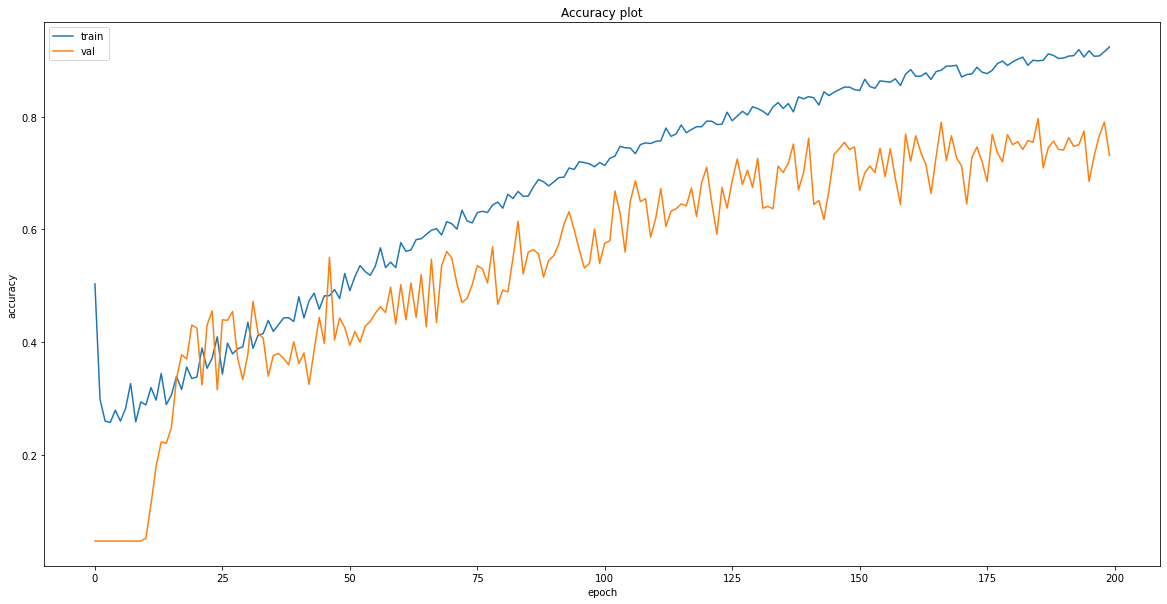

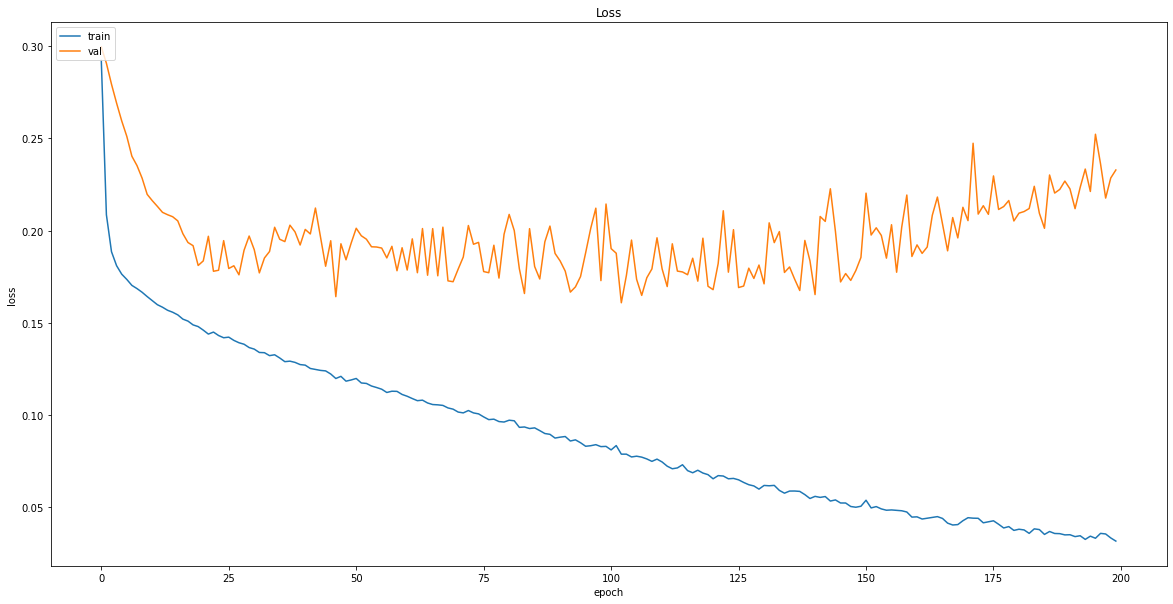

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [128]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [129]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [130]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(218, 15, 4)

In [131]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [132]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2364 - accuracy: 0.6468 - mean_squared_error: 7.9628 - weighted_accuracy: 0.6468 - weighted_mean_squared_error: 7.9628
Test loss: 0.2364450842142105
Test accuracy: 0.646789014339447


In [133]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 30, 2: 146, 0: 42})

In [134]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [135]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [136]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,1,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,2,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,0,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


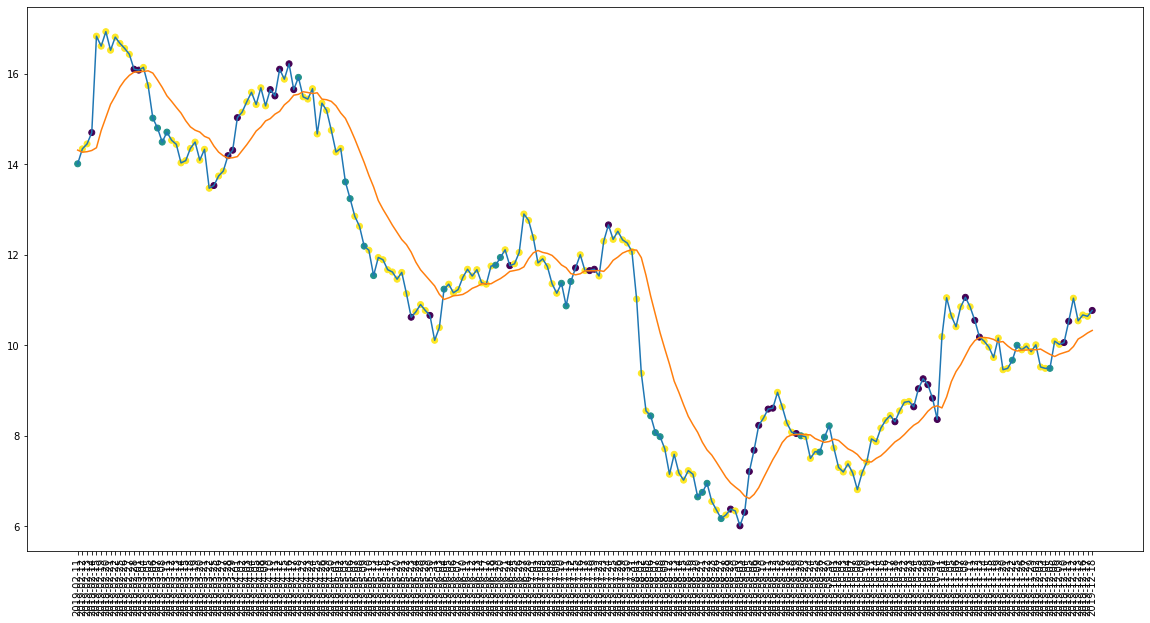

In [137]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

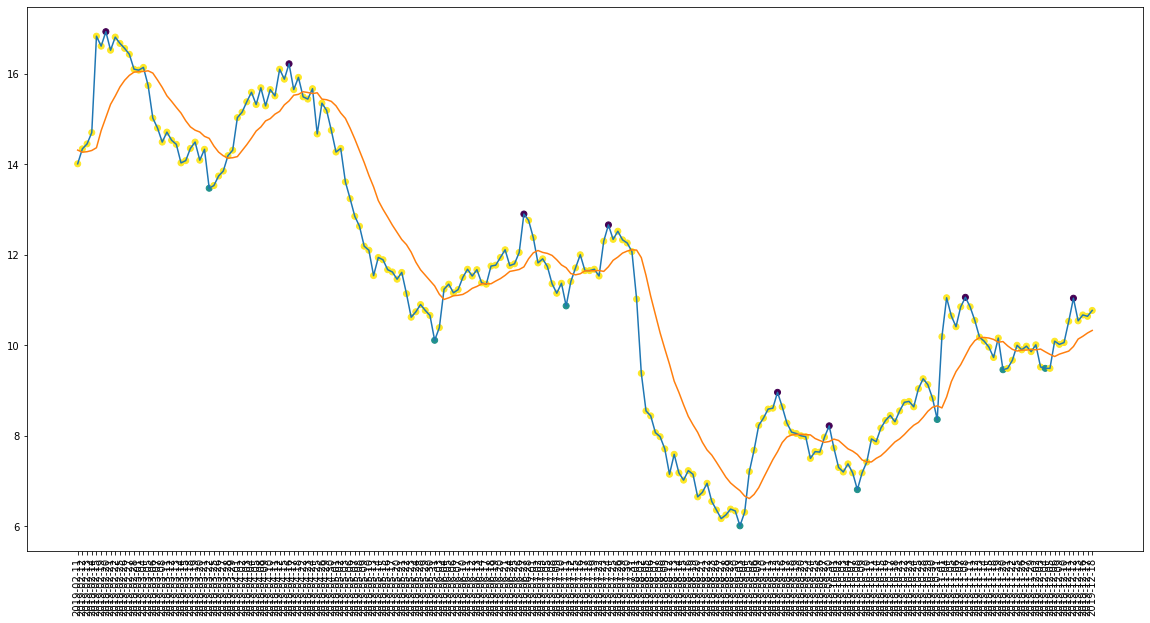

In [138]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [139]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 28
actual holds but predicted sell: 37
actual predicted holds: 137
Percentage buys correct: 12.5%
Percentage sells correct: 37.5%
Percentage holds correct: 67.82178217821782%
actual buys: 8
actual sells: 8
actual holds: 202


In [140]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 31.70731707317073%
Percentage holds correct: 86.98630136986301%


In [141]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Price increase from previously bought: 14.602759032528411%
Share price: $16.100000381469727
Shares owned at the moment: 0
Cash capital at the moment: $11427.1175297966


Share price: $15.020000457763672
Shares owned at the moment: 758
Cash capital at the moment: $10.647991857527813


Stop Loss Activated!

Share price: $14.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $10963.8634138422


Share price: $14.489999771118164
Shares owned at the moment: 754
Cash capital at the moment: $8.358571893690169


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $10557.887166107654


Share price: $15.920000076293945
Shares owned at the moment: 661
Cash capital at the moment: $5.8285355386724405


Stop Loss Activated!

Share price: $15.4399995803833
Shares owned at the moment: 0
Cash capital at the 

In [142]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [143]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [144]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [145]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [146]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2363 - accuracy: 0.6895 - mean_squared_error: 7.7319 - weighted_accuracy: 0.6895 - weighted_mean_squared_error: 7.7319
Test loss: 0.2363015115261078
Test accuracy: 0.689497709274292


In [147]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 166, 1: 29, 0: 24})

In [148]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [149]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [150]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,2,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,2,2


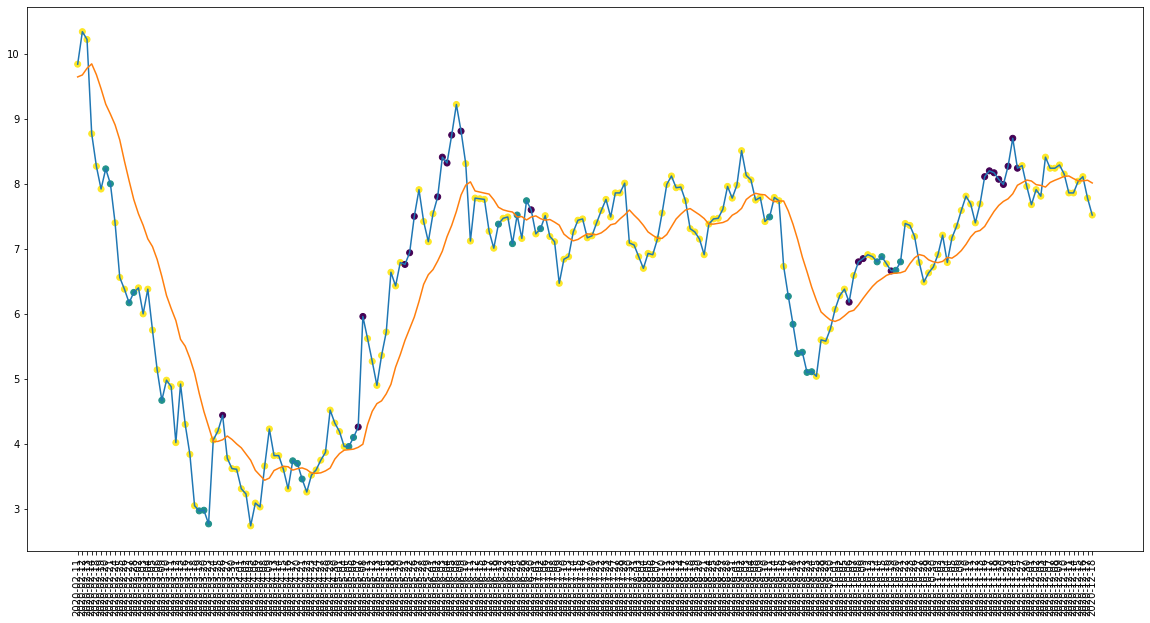

In [151]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

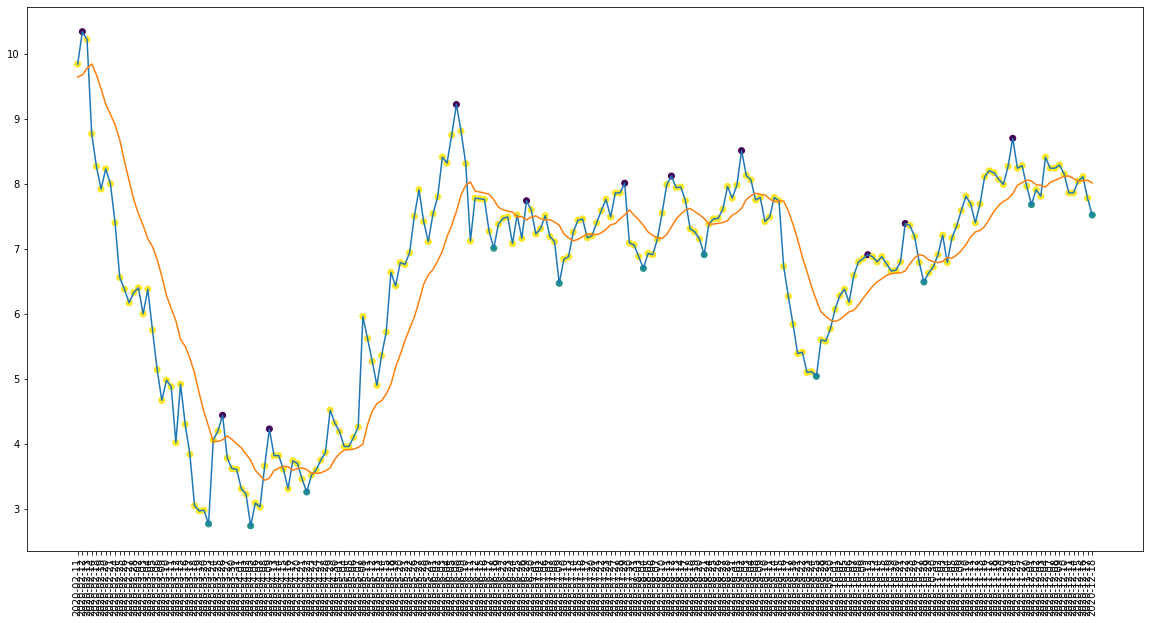

In [152]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 27
actual holds but predicted sell: 22
actual predicted holds: 148
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 75.1269035532995%
actual buys: 11
actual sells: 11
actual holds: 197


In [154]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 58.62068965517241%
Percentage sells correct: 62.5%
Percentage holds correct: 84.84848484848484%


In [155]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.229999542236326
Shares owned at the moment: 1211
Cash capital at the moment: $6.062598376274764


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9667.420598376275


Share price: $8.0
Shares owned at the moment: 1205
Cash capital at the moment: $0.9105983762747201


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $8893.388962978006


Share price: $6.170000076293945
Shares owned at the moment: 1437
Cash capital at the moment: $2.7165555421124736


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $8601.006055542111


Share price: $4.670000076293945
Shares owned at the moment: 1836
Cash capital at the moment: $3.307085081220066


Stop Loss Activated!

Share price: $4.019999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7363.730070158601


Share price: $2.970000028610228
Shares owned at the 

In [156]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
